In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from typing import Tuple, Optional
cuda0 = torch.device("cuda")

In [26]:
def tensor_basics_demo():
    """Demonstrate fundamental tensor operations"""
    # TODO: Create tensors from different sources
    # 1. From Python list
    list_tensor = torch.tensor(
        [
            23,55,23,5,234,735,3,0.2
        ]
    )
    print(list_tensor)
    
    # 2. From NumPy array
    np_array = np.array([[1, 2, 3], [4, 5, 6]])
    numpy_tensor = torch.from_numpy(np_array)
    print(numpy_tensor)
    
    # 3. Random tensor with specific shape
    random_tensor = torch.rand((4,4))
    random_tensor.to(cuda0, dtype=torch.float64)
    print(random_tensor)
    print(random_tensor@random_tensor)
    print(random_tensor.device)
    print(torch.mm(random_tensor,random_tensor))
    # TODO: Perform basic operations
    # Addition, multiplication, matrix operations
    
    add_tensor_L = list_tensor + list_tensor
    print(add_tensor_L)
    
    add_tensor_L.to(cuda0, dtype = torch.float64)
    # TODO: Demonstrate tensor properties
    # Shape, dtype, device
    
    return list_tensor, numpy_tensor, random_tensor

In [27]:
if __name__ == "__main__":
    tensor_basics_demo()

tensor([2.3000e+01, 5.5000e+01, 2.3000e+01, 5.0000e+00, 2.3400e+02, 7.3500e+02,
        3.0000e+00, 2.0000e-01])
tensor([[1, 2, 3],
        [4, 5, 6]], dtype=torch.int32)
tensor([[0.8225, 0.3136, 0.5887, 0.1960],
        [0.4702, 0.3784, 0.0131, 0.1308],
        [0.4982, 0.3228, 0.4495, 0.3389],
        [0.2393, 0.7172, 0.1341, 0.2664]])
tensor([[1.1641, 0.7072, 0.7792, 0.4540],
        [0.6025, 0.3887, 0.3052, 0.1810],
        [0.8665, 0.6665, 0.5450, 0.3825],
        [0.6646, 0.5807, 0.2463, 0.2571]])
cpu
tensor([[1.1641, 0.7072, 0.7792, 0.4540],
        [0.6025, 0.3887, 0.3052, 0.1810],
        [0.8665, 0.6665, 0.5450, 0.3825],
        [0.6646, 0.5807, 0.2463, 0.2571]])
tensor([4.6000e+01, 1.1000e+02, 4.6000e+01, 1.0000e+01, 4.6800e+02, 1.4700e+03,
        6.0000e+00, 4.0000e-01])


In [29]:
import torch.optim as optim
import matplotlib.pyplot as plt

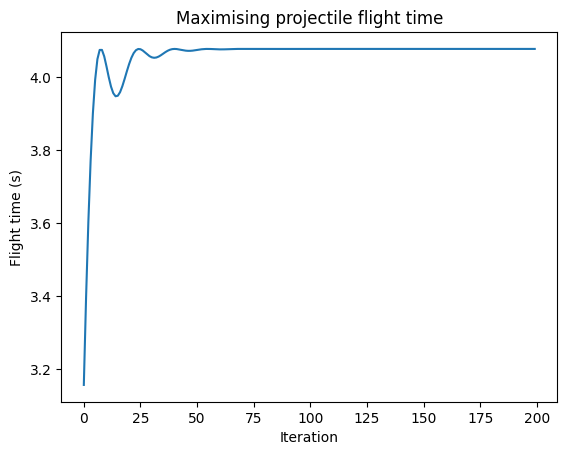

Optimal angle (deg): 89.99908725912938
Maximum flight time (s): 4.077471733093262


In [31]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

class MaxFlightTime:
    def __init__(self, velocity=20.0, gravity=9.81):
        self.v = velocity
        self.g = gravity
        # Optimisable parameter: angle
        self.angle = torch.tensor(torch.pi/4, requires_grad=True)  # start at 45°
    
    def flight_time(self):
        return 2 * self.v * torch.sin(self.angle) / self.g
    
    def loss_function(self):
        # We want to maximise time → minimise negative time
        return -self.flight_time()
    
    def optimise(self, steps=200, lr=0.1):
        opt = optim.Adam([self.angle], lr=lr)
        times, losses = [], []
        for _ in range(steps):
            opt.zero_grad()
            loss = self.loss_function()
            loss.backward()
            opt.step()
            times.append(self.flight_time().item())
            losses.append(loss.item())
        return times, losses

# Run optimisation
opt = MaxFlightTime(velocity=20.0)
times, losses = opt.optimise()

# Plot flight time improvement
plt.plot(times)
plt.xlabel("Iteration")
plt.ylabel("Flight time (s)")
plt.title("Maximising projectile flight time")
plt.show()

print("Optimal angle (deg):", opt.angle.item()*180/torch.pi)
print("Maximum flight time (s):", times[-1])


Optimised angle (deg): 45.99531007847168
Flight time (s): 2.9328558444976807
Range (m): 40.7501106262207


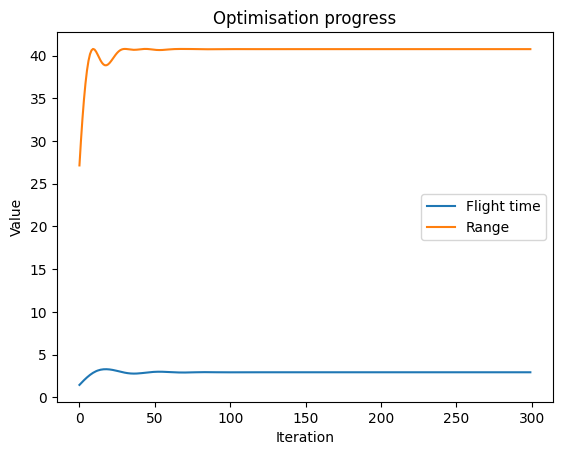

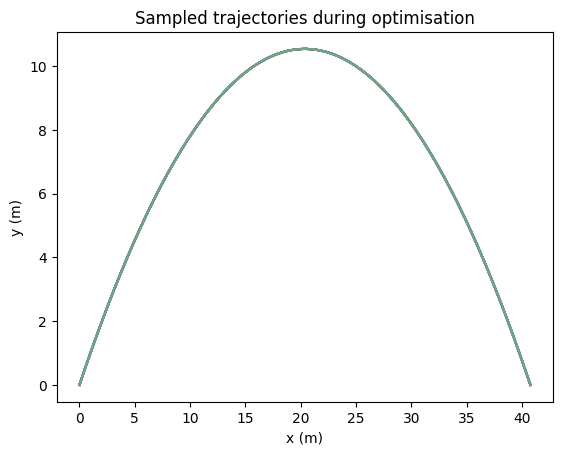

In [33]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class FlightRangeOptimiser:
    def __init__(self, velocity=20.0, gravity=9.81, w_time=0.5, w_range=0.5):
        self.v = velocity
        self.g = gravity
        self.angle = torch.tensor(torch.pi/10, requires_grad=True)  # initial guess
        self.w_time = w_time
        self.w_range = w_range
    
    def flight_time(self):
        return 2 * self.v * torch.sin(self.angle) / self.g
    
    def range(self):
        return self.v**2 * torch.sin(2*self.angle) / self.g
    
    def loss(self):
        # minimise negative weighted sum
        return -(self.w_time*self.flight_time() + self.w_range*self.range())
    
    def optimise(self, steps=300, lr=0.05):
        opt = optim.Adam([self.angle], lr=lr)
        times, ranges = [], []
        for _ in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()
            times.append(self.flight_time().item())
            ranges.append(self.range().item())
        return times, ranges

    def trajectory(self, n_points=200):
        θ = self.angle.item()
        t_flight = 2 * self.v * np.sin(θ) / self.g
        t = np.linspace(0, t_flight, n_points)
        x = self.v * np.cos(θ) * t
        y = self.v * np.sin(θ) * t - 0.5 * self.g * t**2
        return x, y

# --- Run with velocity fixed ---
opt = FlightRangeOptimiser(velocity=20.0, w_time=0.5, w_range=0.5)
times, ranges = opt.optimise()

print("Optimised angle (deg):", opt.angle.item()*180/np.pi)
print("Flight time (s):", times[-1])
print("Range (m):", ranges[-1])

# Plot optimisation history
plt.figure()
plt.plot(times, label="Flight time")
plt.plot(ranges, label="Range")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.title("Optimisation progress")
plt.show()

# Plot trajectories every 10 iterations
plt.figure()
for i in range(0, len(times), 10):
    θ = float(opt.angle.item())  # after last step
    # reconstruct trajectory at that sampled angle
    t_f = 2*opt.v*np.sin(θ)/opt.g
    t = np.linspace(0, t_f, 200)
    x = opt.v*np.cos(θ)*t
    y = opt.v*np.sin(θ)*t - 0.5*opt.g*t**2
    plt.plot(x, y, alpha=0.5)

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Sampled trajectories during optimisation")
plt.show()

Optimised velocity: 18.63892936706543
Optimised angle (deg): 49.741484423116084


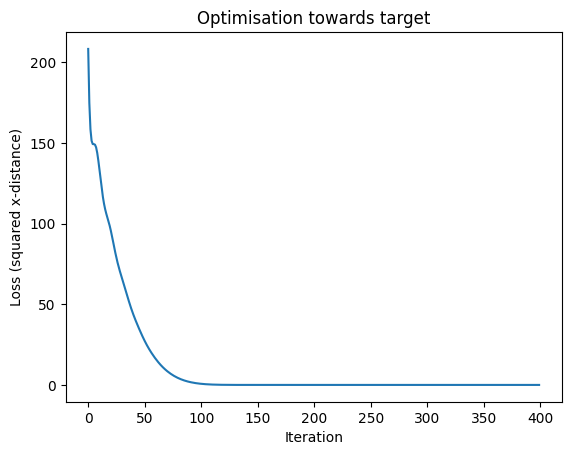

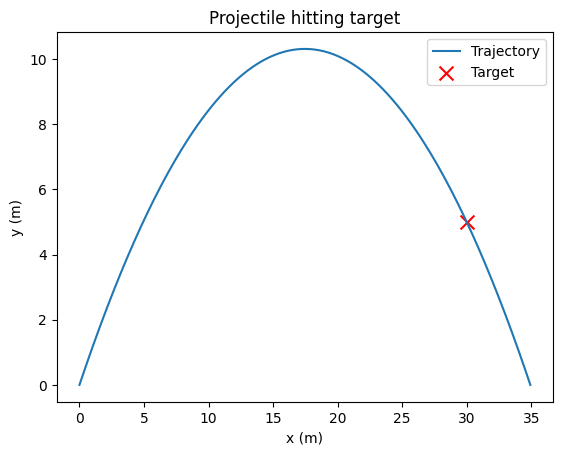

In [82]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class ProjectileTargetOptimiser:
    def __init__(self, target_x, target_y, gravity=9.81):
        self.target_x = target_x
        self.target_y = target_y
        self.g = gravity

        # Optimisable parameters
        self.velocity = torch.tensor(15.0, requires_grad=True)  # initial guess
        self.angle = torch.tensor(torch.pi/4, requires_grad=True)  # initial guess

    def endpoint(self):
        """Compute x position when projectile passes through target_y plane"""
        v, θ, g = self.velocity, self.angle, self.g

        # Solve quadratic: y(t) = v*sinθ*t - 0.5*g*t² = target_y
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y
        disc = b**2 - 4*a*c

        if disc < 0:
            return torch.tensor(float("inf"))  # unreachable
        t1 = (-b + torch.sqrt(disc)) / (2*a)
        t2 = (-b - torch.sqrt(disc)) / (2*a)
        t_hit = torch.max(t1, t2)  # take positive root

        x_hit = v * torch.cos(θ) * t_hit
        return x_hit

    def loss(self):
        """Squared distance in x at target_y"""
        x_hit = self.endpoint()
        return (x_hit - self.target_x)**2

    def optimise(self, steps=400, lr=0.05):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        history = []
        for _ in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()
            history.append(L.item())
        return history

    def trajectory(self, n_points=200):
        """Full trajectory for plotting"""
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        return x, y


# Example: target at (30, 5)
opt = ProjectileTargetOptimiser(target_x=30.0, target_y=5.0)
losses = opt.optimise()

print("Optimised velocity:", opt.velocity.item())
print("Optimised angle (deg):", opt.angle.item()*180/np.pi)

# Plot convergence
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss (squared x-distance)")
plt.title("Optimisation towards target")
plt.show()

# Plot trajectory vs target
x, y = opt.trajectory()
plt.figure()
plt.plot(x, y, label="Trajectory")
plt.scatter(opt.target_x, opt.target_y, c="red", marker="x", s=100, label="Target")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.title("Projectile hitting target")
plt.show()


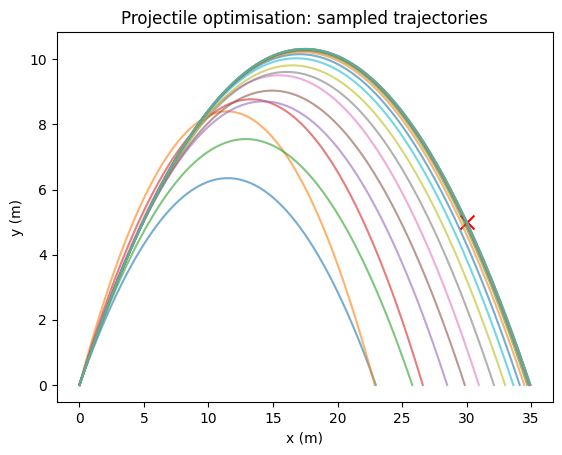

Final velocity: 18.639694213867188
Final angle (deg): 49.74131366838684


In [36]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class ProjectileTargetOptimiser:
    def __init__(self, target_x, target_y, gravity=9.81):
        self.target_x = target_x
        self.target_y = target_y
        self.g = gravity

        # Optimisable parameters
        self.velocity = torch.tensor(15.0, requires_grad=True)
        self.angle = torch.tensor(torch.pi/4, requires_grad=True)

    def endpoint(self):
        v, θ, g = self.velocity, self.angle, self.g

        # Solve quadratic: y(t) = v*sinθ*t - 0.5*g*t² = target_y
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y
        disc = b**2 - 4*a*c

        if disc < 0:
            return torch.tensor(float("inf"))
        t1 = (-b + torch.sqrt(disc)) / (2*a)
        t2 = (-b - torch.sqrt(disc)) / (2*a)
        t_hit = torch.max(t1, t2)
        x_hit = v * torch.cos(θ) * t_hit
        return x_hit

    def loss(self):
        x_hit = self.endpoint()
        return (x_hit - self.target_x)**2

    def trajectory(self, n_points=200):
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        return x, y

    def optimise_and_plot(self, steps=200, lr=0.05, plot_every=10):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        losses = []

        plt.figure()
        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()
            losses.append(L.item())

            # Plot every 'plot_every' steps including first
            if step % plot_every == 0:
                x, y = self.trajectory()
                plt.plot(x, y, alpha=0.6, label=f"Step {step}")

        # Mark target
        plt.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.title("Projectile optimisation: sampled trajectories")
        plt.show()

        return losses


# Example usage
opt = ProjectileTargetOptimiser(target_x=30.0, target_y=5.0)
losses = opt.optimise_and_plot()

print("Final velocity:", opt.velocity.item())
print("Final angle (deg):", opt.angle.item()*180/np.pi)

In [37]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os

class ProjectileTargetOptimiser:
    def __init__(self, target_x, target_y, gravity=9.81):
        self.target_x = target_x
        self.target_y = target_y
        self.g = gravity

        # Optimisable parameters
        self.velocity = torch.tensor(15.0, requires_grad=True)
        self.angle = torch.tensor(torch.pi/4, requires_grad=True)

    def endpoint(self):
        v, θ, g = self.velocity, self.angle, self.g
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y
        disc = b**2 - 4*a*c
        if disc < 0:
            return torch.tensor(float("inf"))
        t1 = (-b + torch.sqrt(disc)) / (2*a)
        t2 = (-b - torch.sqrt(disc)) / (2*a)
        t_hit = torch.max(t1, t2)
        x_hit = v * torch.cos(θ) * t_hit
        return x_hit

    def loss(self):
        x_hit = self.endpoint()
        return (x_hit - self.target_x)**2

    def trajectory(self, n_points=200):
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        return x, y

    def optimise_and_gif(self, steps=100, lr=0.05, gif_name="optimisation.gif"):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            # Print speed + angle
            print(f"Step {step}: v={self.velocity.item():.2f}, angle={self.angle.item()*180/np.pi:.2f} deg")

            # Plot trajectory
            fig, ax = plt.subplots()
            x, y = self.trajectory()
            ax.plot(x, y, label=f"Step {step}")
            ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")
            ax.set_xlabel("x (m)")
            ax.set_ylabel("y (m)")
            ax.set_title("Projectile optimisation")
            ax.legend()

            # Save frame to array
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        # Write GIF
        imageio.mimsave(gif_name, frames, fps=5)
        print(f"Saved {gif_name}")


# Example usage
opt = ProjectileTargetOptimiser(target_x=30.0, target_y=5.0)
opt.optimise_and_gif()

Step 0: v=15.05, angle=47.86 deg
Step 1: v=15.10, angle=50.51 deg
Step 2: v=15.15, angle=52.84 deg


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\885218197.py:69: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 3: v=15.20, angle=54.75 deg
Step 4: v=15.25, angle=56.17 deg
Step 5: v=15.29, angle=57.08 deg
Step 6: v=15.34, angle=57.51 deg
Step 7: v=15.39, angle=57.51 deg
Step 8: v=15.44, angle=57.16 deg
Step 9: v=15.49, angle=56.54 deg
Step 10: v=15.53, angle=55.73 deg
Step 11: v=15.58, angle=54.80 deg
Step 12: v=15.63, angle=53.81 deg
Step 13: v=15.67, angle=52.81 deg
Step 14: v=15.72, angle=51.88 deg
Step 15: v=15.77, angle=51.05 deg
Step 16: v=15.82, angle=50.37 deg
Step 17: v=15.86, angle=49.86 deg
Step 18: v=15.91, angle=49.55 deg
Step 19: v=15.96, angle=49.44 deg
Step 20: v=16.00, angle=49.50 deg
Step 21: v=16.05, angle=49.71 deg
Step 22: v=16.10, angle=50.04 deg
Step 23: v=16.15, angle=50.44 deg
Step 24: v=16.19, angle=50.90 deg
Step 25: v=16.24, angle=51.35 deg
Step 26: v=16.28, angle=51.78 deg
Step 27: v=16.33, angle=52.17 deg
Step 28: v=16.37, angle=52.47 deg
Step 29: v=16.42, angle=52.69 deg
Step 30: v=16.46, angle=52.82 deg
Step 31: v=16.51, angle=52.85 deg
Step 32: v=16.55, ang

In [38]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio

class ProjectileTargetOptimiser:
    def __init__(self, target_x, target_y, gravity=9.81):
        self.target_x = target_x
        self.target_y = target_y
        self.g = gravity

        # Optimisable parameters
        self.velocity = torch.tensor(15.0, requires_grad=True)
        self.angle = torch.tensor(torch.pi/4, requires_grad=True)

    def endpoint(self):
        v, θ, g = self.velocity, self.angle, self.g
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y
        disc = b**2 - 4*a*c
        if disc < 0:
            return torch.tensor(float("inf"))
        t1 = (-b + torch.sqrt(disc)) / (2*a)
        t2 = (-b - torch.sqrt(disc)) / (2*a)
        t_hit = torch.max(t1, t2)
        x_hit = v * torch.cos(θ) * t_hit
        return x_hit

    def loss(self):
        x_hit = self.endpoint()
        return (x_hit - self.target_x)**2

    def trajectory(self, n_points=200):
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        return x, y

    def optimise_and_gif(self, steps=500, lr=0.05, gif_name="optimisation.gif", save_every=20):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []
        all_trajectories = []

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            # Print speed + angle
            print(f"Step {step}: v={self.velocity.item():.2f}, angle={self.angle.item()*180/np.pi:.2f} deg")

            # Store trajectory
            all_trajectories.append(self.trajectory())

            # Save a frame only every `save_every` steps
            if step % save_every == 0:
                fig, ax = plt.subplots()
                for i, (x, y) in enumerate(all_trajectories):
                    alpha = 0.3 + 0.7*(i/len(all_trajectories))  # later trajectories darker
                    ax.plot(x, y, alpha=alpha)
                ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                ax.set_title(f"Projectile optimisation up to step {step}")
                ax.legend()

                # Convert plot to image array
                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(frame)
                plt.close(fig)

        # Write GIF
        imageio.mimsave(gif_name, frames, fps=2)
        print(f"Saved {gif_name}")


# Example usage
opt = ProjectileTargetOptimiser(target_x=30.0, target_y=5.0)
opt.optimise_and_gif()


Step 0: v=15.05, angle=47.86 deg
Step 1: v=15.10, angle=50.51 deg
Step 2: v=15.15, angle=52.84 deg
Step 3: v=15.20, angle=54.75 deg
Step 4: v=15.25, angle=56.17 deg
Step 5: v=15.29, angle=57.08 deg
Step 6: v=15.34, angle=57.51 deg
Step 7: v=15.39, angle=57.51 deg
Step 8: v=15.44, angle=57.16 deg
Step 9: v=15.49, angle=56.54 deg
Step 10: v=15.53, angle=55.73 deg
Step 11: v=15.58, angle=54.80 deg
Step 12: v=15.63, angle=53.81 deg
Step 13: v=15.67, angle=52.81 deg
Step 14: v=15.72, angle=51.88 deg
Step 15: v=15.77, angle=51.05 deg
Step 16: v=15.82, angle=50.37 deg
Step 17: v=15.86, angle=49.86 deg
Step 18: v=15.91, angle=49.55 deg
Step 19: v=15.96, angle=49.44 deg
Step 20: v=16.00, angle=49.50 deg


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\1265455154.py:74: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 21: v=16.05, angle=49.71 deg
Step 22: v=16.10, angle=50.04 deg
Step 23: v=16.15, angle=50.44 deg
Step 24: v=16.19, angle=50.90 deg
Step 25: v=16.24, angle=51.35 deg
Step 26: v=16.28, angle=51.78 deg
Step 27: v=16.33, angle=52.17 deg
Step 28: v=16.37, angle=52.47 deg
Step 29: v=16.42, angle=52.69 deg
Step 30: v=16.46, angle=52.82 deg
Step 31: v=16.51, angle=52.85 deg
Step 32: v=16.55, angle=52.79 deg
Step 33: v=16.60, angle=52.64 deg
Step 34: v=16.64, angle=52.44 deg
Step 35: v=16.68, angle=52.18 deg
Step 36: v=16.72, angle=51.88 deg
Step 37: v=16.76, angle=51.57 deg
Step 38: v=16.81, angle=51.26 deg
Step 39: v=16.85, angle=50.97 deg
Step 40: v=16.89, angle=50.71 deg
Step 41: v=16.93, angle=50.48 deg
Step 42: v=16.97, angle=50.31 deg
Step 43: v=17.01, angle=50.18 deg
Step 44: v=17.05, angle=50.11 deg
Step 45: v=17.09, angle=50.08 deg
Step 46: v=17.12, angle=50.10 deg
Step 47: v=17.16, angle=50.15 deg
Step 48: v=17.20, angle=50.23 deg
Step 49: v=17.24, angle=50.33 deg
Step 50: v=17.

In [39]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio

class ProjectileTargetOptimiser:
    def __init__(self, target_x, target_y, gravity=9.81):
        self.target_x = target_x
        self.target_y = target_y
        self.g = gravity

        # Optimisable parameters
        self.velocity = torch.tensor(15.0, requires_grad=True)
        self.angle = torch.tensor(torch.pi/4, requires_grad=True)

    def endpoint(self):
        v, θ, g = self.velocity, self.angle, self.g
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y
        disc = b**2 - 4*a*c
        if disc < 0:
            return torch.tensor(float("inf"))
        t1 = (-b + torch.sqrt(disc)) / (2*a)
        t2 = (-b - torch.sqrt(disc)) / (2*a)
        t_hit = torch.max(t1, t2)
        x_hit = v * torch.cos(θ) * t_hit
        return x_hit

    def loss(self):
        x_hit = self.endpoint()
        return (x_hit - self.target_x)**2

    def trajectory(self, n_points=200):
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        return x, y

    def optimise_and_gif(self, steps=200, lr=0.05, gif_name="optimisation.gif", save_every=20):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []
        sampled_trajectories = []

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            # Print speed + angle every step
            print(f"Step {step}: v={self.velocity.item():.2f}, angle={self.angle.item()*180/np.pi:.2f} deg")

            # Save trajectory and frame only every `save_every` steps
            if step % save_every == 0:
                sampled_trajectories.append(self.trajectory())

                fig, ax = plt.subplots()
                for i, (x, y) in enumerate(sampled_trajectories):
                    ax.plot(x, y, label=f"Step {i*save_every}")
                ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                ax.set_title(f"Trajectories up to step {step}")
                ax.legend()

                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(frame)
                plt.close(fig)

        # Write GIF
        imageio.mimsave(gif_name, frames, fps=2)
        print(f"Saved {gif_name}")


# Example usage
opt = ProjectileTargetOptimiser(target_x=30.0, target_y=5.0)
opt.optimise_and_gif()

Step 0: v=15.05, angle=47.86 deg
Step 1: v=15.10, angle=50.51 deg
Step 2: v=15.15, angle=52.84 deg
Step 3: v=15.20, angle=54.75 deg
Step 4: v=15.25, angle=56.17 deg
Step 5: v=15.29, angle=57.08 deg
Step 6: v=15.34, angle=57.51 deg
Step 7: v=15.39, angle=57.51 deg
Step 8: v=15.44, angle=57.16 deg
Step 9: v=15.49, angle=56.54 deg
Step 10: v=15.53, angle=55.73 deg
Step 11: v=15.58, angle=54.80 deg
Step 12: v=15.63, angle=53.81 deg
Step 13: v=15.67, angle=52.81 deg
Step 14: v=15.72, angle=51.88 deg
Step 15: v=15.77, angle=51.05 deg
Step 16: v=15.82, angle=50.37 deg
Step 17: v=15.86, angle=49.86 deg
Step 18: v=15.91, angle=49.55 deg
Step 19: v=15.96, angle=49.44 deg
Step 20: v=16.00, angle=49.50 deg
Step 21: v=16.05, angle=49.71 deg
Step 22: v=16.10, angle=50.04 deg
Step 23: v=16.15, angle=50.44 deg
Step 24: v=16.19, angle=50.90 deg
Step 25: v=16.24, angle=51.35 deg
Step 26: v=16.28, angle=51.78 deg
Step 27: v=16.33, angle=52.17 deg
Step 28: v=16.37, angle=52.47 deg
Step 29: v=16.42, angle=

C:\Users\jones\AppData\Local\Temp\ipykernel_61084\2284209071.py:71: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 40: v=16.89, angle=50.71 deg
Step 41: v=16.93, angle=50.48 deg
Step 42: v=16.97, angle=50.31 deg
Step 43: v=17.01, angle=50.18 deg
Step 44: v=17.05, angle=50.11 deg
Step 45: v=17.09, angle=50.08 deg
Step 46: v=17.12, angle=50.10 deg
Step 47: v=17.16, angle=50.15 deg
Step 48: v=17.20, angle=50.23 deg
Step 49: v=17.24, angle=50.33 deg
Step 50: v=17.27, angle=50.44 deg
Step 51: v=17.31, angle=50.55 deg
Step 52: v=17.34, angle=50.65 deg
Step 53: v=17.38, angle=50.75 deg
Step 54: v=17.41, angle=50.82 deg
Step 55: v=17.45, angle=50.88 deg
Step 56: v=17.48, angle=50.92 deg
Step 57: v=17.51, angle=50.94 deg
Step 58: v=17.55, angle=50.93 deg
Step 59: v=17.58, angle=50.90 deg
Step 60: v=17.61, angle=50.86 deg
Step 61: v=17.64, angle=50.80 deg
Step 62: v=17.67, angle=50.73 deg
Step 63: v=17.70, angle=50.65 deg
Step 64: v=17.73, angle=50.57 deg
Step 65: v=17.76, angle=50.48 deg
Step 66: v=17.79, angle=50.40 deg
Step 67: v=17.81, angle=50.32 deg
Step 68: v=17.84, angle=50.24 deg
Step 69: v=17.

In [48]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio

class ProjectileTargetOptimiser:
    def __init__(self, target_x, target_y, gravity=9.81):
        self.target_x = target_x
        self.target_y = target_y
        self.g = gravity

        # Optimisable parameters
        self.velocity = torch.tensor(20.0, requires_grad=True)
        self.angle = torch.tensor(torch.pi/3, requires_grad=True)

    def endpoint(self):
        v, θ, g = self.velocity, self.angle, self.g
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y
        disc = b**2 - 4*a*c

        if disc < 0:
            return None  # unreachable

        sqrt_disc = torch.sqrt(disc)
        t1 = (-b + sqrt_disc) / (2*a)
        t2 = (-b - sqrt_disc) / (2*a)

        # Time of apex
        t_apex = b / g

        # Smallest positive root < t_apex
        candidates = [t for t in [t1, t2] if t > 0 and t < t_apex]
        if not candidates:
            return None  # cannot hit on ascent

        t_hit = min(candidates)
        x_hit = v * torch.cos(θ) * t_hit
        return x_hit

    def loss(self):
        x_hit = self.endpoint()
        if x_hit is None:
            # Differentiable penalty: distance to apex x position
            t_apex = self.velocity * torch.sin(self.angle) / self.g
            x_apex = self.velocity * torch.cos(self.angle) * t_apex
            return (x_apex - self.target_x)**2
        return (x_hit - self.target_x)**2


    def trajectory(self, n_points=500):
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        # apex
        t_apex = v*np.sin(θ)/g
        x_apex = v*np.cos(θ)*t_apex
        y_apex = v*np.sin(θ)*t_apex - 0.5*g*t_apex**2
        return x, y, (x_apex, y_apex)

    def optimise_and_gif(self, steps=500, lr=0.01, gif_name="optimisation.gif", save_every=20):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []
        sampled_trajectories = []

        # Set constant axis limits relative to target
        xlim = (0, 1.5*self.target_x)
        ylim = (0, 1.5*self.target_y)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            if step % save_every == 0:
                print(f"Step {step}: v={self.velocity.item():.2f}, angle={self.angle.item()*180/np.pi:.2f} deg")
                x, y, apex = self.trajectory()
                sampled_trajectories.append((x, y, apex))

                fig, ax = plt.subplots()
                # Draw older trajectories faint
                for (xi, yi, ai) in sampled_trajectories[:-1]:
                    ax.plot(xi, yi, color="blue", alpha=0.3, linewidth=1)
                    ax.scatter(*ai, color="grey", s=20, alpha=0.5)
                # Highlight latest
                x, y, apex = sampled_trajectories[-1]
                ax.plot(x, y, color="black", linewidth=2, label=f"Step {step}")
                ax.scatter(*apex, color="orange", s=40, label="Apex")

                # Target
                ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")

                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                ax.set_title(f"Trajectories up to step {step}")
                ax.legend()

                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(frame)
                plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=2)
        print(f"Saved {gif_name}")


# Example usage
opt = ProjectileTargetOptimiser(target_x=np.random.randint(0,100), target_y=np.random.randint(0,100))
opt.optimise_and_gif()

Step 0: v=19.99, angle=59.43 deg
Step 20: v=19.78, angle=47.73 deg


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\2793685201.py:106: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 40: v=19.66, angle=39.72 deg
Step 60: v=19.69, angle=38.77 deg
Step 80: v=19.75, angle=39.16 deg
Step 100: v=19.81, angle=39.72 deg
Step 120: v=19.87, angle=40.24 deg
Step 140: v=19.93, angle=40.68 deg
Step 160: v=19.99, angle=41.06 deg
Step 180: v=20.04, angle=41.38 deg
Step 200: v=20.08, angle=41.64 deg
Step 220: v=20.12, angle=41.85 deg
Step 240: v=20.16, angle=42.03 deg
Step 260: v=20.19, angle=42.18 deg
Step 280: v=20.21, angle=42.30 deg
Step 300: v=20.23, angle=42.39 deg
Step 320: v=20.25, angle=42.47 deg
Step 340: v=20.27, angle=42.54 deg
Step 360: v=20.28, angle=42.59 deg
Step 380: v=20.29, angle=42.63 deg
Step 400: v=20.30, angle=42.66 deg
Step 420: v=20.31, angle=42.69 deg
Step 440: v=20.31, angle=42.71 deg
Step 460: v=20.32, angle=42.73 deg
Step 480: v=20.32, angle=42.74 deg
Saved optimisation.gif


In [55]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from typing import Tuple, Optional

class ProjectileTargetOptimiserMulti:
    def __init__(self, target_x: float, target_y: float, gravity: float = 9.81,
                 w_target: float = 1.0, w_time: float = 0.05):
        self.target_x = target_x
        self.target_y = target_y
        print(f"Target: ({self.target_x}, {self.target_y})")
        self.g = gravity
        self.w_target = w_target
        self.w_time = w_time

        # Optimisable parameters
        self.velocity = torch.tensor(torch.rand(1).item() * 50, requires_grad=True)
        self.angle = torch.tensor(torch.rand(1).item() * (np.pi/2 - 0.01) + 0.01, requires_grad=True)

    def endpoint(self) -> Optional[torch.Tensor]:
        v, θ, g = self.velocity, self.angle, self.g
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y

        disc = torch.clamp(b**2 - 4*a*c, min=1e-6)
        sqrt_disc = torch.sqrt(disc)
        t1 = (-b + sqrt_disc) / (2*a)
        t2 = (-b - sqrt_disc) / (2*a)

        t_apex = b / g
        candidates = [t for t in [t1, t2] if t > 0 and t < t_apex]
        if not candidates:
            return None

        t_hit = min(candidates)
        x_hit = v * torch.cos(θ) * t_hit
        return x_hit

    def total_flight_time(self) -> torch.Tensor:
        """Total flight time"""
        return 2*self.velocity*torch.sin(self.angle)/self.g

    def loss(self) -> torch.Tensor:
        x_hit = self.endpoint()
        if x_hit is None:
            # penalty if cannot hit target
            t_apex = self.velocity*torch.sin(self.angle)/self.g
            x_apex = self.velocity*torch.cos(self.angle)*t_apex
            target_loss = (x_apex - self.target_x)**2
        else:
            target_loss = (x_hit - self.target_x)**2

        # Multi-objective: subtract flight time (to maximise)
        return self.w_target*target_loss - self.w_time*self.total_flight_time()

    def trajectory(self, n_points: int = 501) -> Tuple[np.ndarray, np.ndarray, Tuple[float,float]]:
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        t_apex = v*np.sin(θ)/g
        x_apex = v*np.cos(θ)*t_apex
        y_apex = v*np.sin(θ)*t_apex - 0.5*g*t_apex**2
        return x, y, (x_apex, y_apex)

    def optimise_and_gif(
        self,
        steps: int = 1000000,
        lr: float = 0.05,
        gif_name: str = "optimisation_multi.gif",
        save_every: int = 100,
        early_stop_tol: float = 1e-6
    ):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []
        sampled_trajectories = []
        xlim = (0, 1.5*self.target_x)
        ylim = (0, 1.5*self.target_y)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            # Bound parameters
            self.velocity.data.clamp_(0.1, 50.0)
            self.angle.data.clamp_(0.01, np.pi/2-0.01)

            if L.item() < early_stop_tol:
                print(f"Converged at step {step}")
                break

            if step % save_every == 0:
                print(f"Step {step}: v={self.velocity.item():.2f}, angle={self.angle.item()*180/np.pi:.2f} deg")
                x, y, apex = self.trajectory()
                sampled_trajectories.append((x, y, apex))

                fig, ax = plt.subplots()
                n_traj = len(sampled_trajectories)
                cmap = plt.get_cmap("Blues")

                for i, (xi, yi, ai) in enumerate(sampled_trajectories[:-1]):
                    alpha = 0.3 + 0.7*(i/(n_traj-1)) if n_traj > 1 else 0.5
                    ax.plot(xi, yi, color=cmap(alpha), linewidth=1)
                    ax.scatter(*ai, color="grey", s=20, alpha=0.5)

                # Latest trajectory
                x, y, apex = sampled_trajectories[-1]
                ax.plot(x, y, color="black", linewidth=2, label=f"Step {step}")
                ax.scatter(*apex, color="orange", s=40, label="Apex")

                ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")
                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                ax.set_title(f"Trajectories up to step {step}")
                if step == 0:
                    ax.legend()
                fig.tight_layout()
                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(frame)
                plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=2)
        print(f"Saved {gif_name}")


# Example usage
if __name__ == "__main__":
    opt = ProjectileTargetOptimiserMulti(target_x=np.random.randint(0,100), target_y=np.random.randint(0,100))
    opt.optimise_and_gif()

Target: (87, 53)
Step 0: v=7.69, angle=48.36 deg


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\963231928.py:127: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 100: v=13.10, angle=44.98 deg
Step 200: v=19.20, angle=45.00 deg
Step 300: v=25.31, angle=45.00 deg
Step 400: v=30.82, angle=45.00 deg
Step 500: v=35.23, angle=45.00 deg
Step 600: v=38.27, angle=45.00 deg
Step 700: v=40.00, angle=45.01 deg
Step 800: v=40.83, angle=45.01 deg
Step 900: v=41.16, angle=45.04 deg
Converged at step 918
Saved optimisation_multi.gif


In [61]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from typing import Tuple, Optional

class ProjectileTargetOptimiserMulti:
    def __init__(self, target_x: float, target_y: float, gravity: float = 9.81,
                 w_target: float = 1.0, w_time: float = 0.05):
        self.target_x = target_x
        self.target_y = target_y
        print(f"Target: ({self.target_x}, {self.target_y})")
        self.g = gravity
        self.w_target = w_target
        self.w_time = w_time

        # Optimisable parameters
        self.velocity = torch.tensor(torch.rand(1).item() * 50, requires_grad=True)
        self.angle = torch.tensor(torch.rand(1).item() * (np.pi/2 - 0.01) + 0.01, requires_grad=True)

    def endpoint(self) -> Optional[torch.Tensor]:
        v, θ, g = self.velocity, self.angle, self.g
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y

        disc = torch.clamp(b**2 - 4*a*c, min=1e-6)
        sqrt_disc = torch.sqrt(disc)
        t1 = (-b + sqrt_disc) / (2*a)
        t2 = (-b - sqrt_disc) / (2*a)

        t_apex = b / g
        candidates = [t for t in [t1, t2] if t > 0 and t < t_apex]
        if not candidates:
            return None

        t_hit = min(candidates)
        x_hit = v * torch.cos(θ) * t_hit
        return x_hit

    def total_flight_time(self) -> torch.Tensor:
        return 2*self.velocity*torch.sin(self.angle)/self.g

    def loss(self) -> torch.Tensor:
        x_hit = self.endpoint()
        if x_hit is None:
            t_apex = self.velocity*torch.sin(self.angle)/self.g
            x_apex = self.velocity*torch.cos(self.angle)*t_apex
            target_loss = (x_apex - self.target_x)**2
        else:
            target_loss = (x_hit - self.target_x)**2
        return self.w_target*target_loss - self.w_time*self.total_flight_time()

    def trajectory(self, n_points: int = 501) -> Tuple[np.ndarray, np.ndarray, Tuple[float,float]]:
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        t_apex = v*np.sin(θ)/g
        x_apex = v*np.cos(θ)*t_apex
        y_apex = v*np.sin(θ)*t_apex - 0.5*g*t_apex**2
        return x, y, (x_apex, y_apex)

    def optimise_and_gif(
        self,
        steps: int = 1000000,
        lr: float = 0.05,
        gif_name: str = "optimisation_multi.gif",
        save_every: int = 100,
        early_stop_tol: float = 1e-6
    ):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []
        sampled_trajectories = []
        xlim = (0, 1.5*self.target_x)
        ylim = (-1.5*abs(self.target_y), 1.5*abs(self.target_y))
        final_trajectory = None

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            # Bound parameters
            self.velocity.data.clamp_(0.1, 100.0)
            self.angle.data.clamp_(-np.pi/2 + 0.01, np.pi/2 - 0.01)

            if L.item() < early_stop_tol:
                print(f"Converged at step {step}")
                final_trajectory = self.trajectory()
                break

            if step % save_every == 0:
                v = self.velocity.item()
                θ = self.angle.item()
                v_x = v * np.cos(θ)
                v_y = v * np.sin(θ)
                print(f"Step {step}: v={v:.2f}, angle={θ*180/np.pi:.2f} deg, "
                      f"v_x={v_x:.2f}, v_y={v_y:.2f}")

                x, y, apex = self.trajectory()
                sampled_trajectories.append((x, y, apex))

                fig, ax = plt.subplots()
                n_traj = len(sampled_trajectories)
                cmap = plt.get_cmap("Blues")

                # Older trajectories
                for i, (xi, yi, ai) in enumerate(sampled_trajectories[:-1]):
                    alpha = 0.3 + 0.7*(i/(n_traj-1)) if n_traj > 1 else 0.5
                    ax.plot(xi, yi, color=cmap(alpha), linewidth=1)
                    ax.scatter(*ai, color="grey", s=20, alpha=0.5)

                # Latest trajectory
                x, y, apex = sampled_trajectories[-1]
                ax.plot(x, y, color="black", linewidth=2, label=f"Step {step}")
                ax.scatter(*apex, color="orange", s=40, label="Apex")

                # Target
                ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")
                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                ax.set_title(f"Trajectories up to step {step}")
                if step == 0:
                    ax.legend()
                fig.tight_layout()
                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(frame)
                plt.close(fig)

        # Plot final trajectory in thick green on all frames
        if final_trajectory is None:
            final_trajectory = self.trajectory()
        x_final, y_final, _ = final_trajectory

        fig, ax = plt.subplots()
        for (xi, yi, _) in sampled_trajectories:
            ax.plot(xi, yi, color='blue', alpha=0.3, linewidth=1)
        ax.plot(x_final, y_final, color='green', linewidth=4, label="Final trajectory")
        ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")
        ax.set_title("Final Optimised Trajectory")
        ax.legend()
        fig.tight_layout()
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=2)
        print(f"Saved {gif_name}")


# Example usage
if __name__ == "__main__":
    opt = ProjectileTargetOptimiserMulti(
        target_x=np.random.randint(0,100),
        target_y=np.random.randint(0,100)
    )
    opt.optimise_and_gif()


Target: (54, 7)
Step 0: v=40.57, angle=76.50 deg, v_x=9.47, v_y=39.45


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\3157151272.py:133: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 100: v=41.12, angle=16.07 deg, v_x=39.51, v_y=11.38
Step 200: v=42.58, angle=14.84 deg, v_x=41.16, v_y=10.90
Step 300: v=43.96, angle=15.20 deg, v_x=42.42, v_y=11.53
Step 400: v=44.82, angle=12.03 deg, v_x=43.83, v_y=9.34
Step 500: v=45.74, angle=13.34 deg, v_x=44.50, v_y=10.55
Step 600: v=46.49, angle=14.32 deg, v_x=45.04, v_y=11.50
Converged at step 689


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\3157151272.py:156: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved optimisation_multi.gif


In [58]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from typing import Tuple, Optional

class ProjectileTargetOptimiserMulti:
    def __init__(self, target_x: float, target_y: float, gravity: float = 9.81,
                 w_target: float = 1.0, w_time: float = 0.05):
        self.target_x = target_x
        self.target_y = target_y
        print(f"Target: ({self.target_x}, {self.target_y})")
        self.g = gravity
        self.w_target = w_target
        self.w_time = w_time

        self.velocity = torch.tensor(torch.rand(1).item() * 50, requires_grad=True)
        self.angle = torch.tensor(torch.rand(1).item() * (np.pi/2 - 0.01) + 0.01, requires_grad=True)

    def endpoint(self) -> Optional[torch.Tensor]:
        v, θ, g = self.velocity, self.angle, self.g
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y

        disc = torch.clamp(b**2 - 4*a*c, min=1e-6)
        sqrt_disc = torch.sqrt(disc)
        t1 = (-b + sqrt_disc) / (2*a)
        t2 = (-b - sqrt_disc) / (2*a)

        t_apex = b / g
        candidates = [t for t in [t1, t2] if t > 0 and t < t_apex]
        if not candidates:
            return None

        t_hit = min(candidates)
        x_hit = v * torch.cos(θ) * t_hit
        return x_hit

    def total_flight_time(self) -> torch.Tensor:
        return 2*self.velocity*torch.sin(self.angle)/self.g

    def loss(self) -> torch.Tensor:
        x_hit = self.endpoint()
        if x_hit is None:
            t_apex = self.velocity*torch.sin(self.angle)/self.g
            x_apex = self.velocity*torch.cos(self.angle)*t_apex
            target_loss = (x_apex - self.target_x)**2
        else:
            target_loss = (x_hit - self.target_x)**2
        return self.w_target*target_loss - self.w_time*self.total_flight_time()

    def trajectory(self, n_points: int = 501) -> Tuple[np.ndarray, np.ndarray, Tuple[float,float]]:
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        t_apex = v*np.sin(θ)/g
        x_apex = v*np.cos(θ)*t_apex
        y_apex = v*np.sin(θ)*t_apex - 0.5*g*t_apex**2
        return x, y, (x_apex, y_apex)

    def optimise_and_gif(
        self,
        steps: int = 1000000,
        lr: float = 0.05,
        gif_name: str = "optimisation_multi_info.gif",
        save_every: int = 100,
        early_stop_tol: float = 1e-9
    ):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []
        sampled_trajectories = []
        xlim = (0, 1.5*self.target_x)
        ylim = (0, 1.5*self.target_y)
        final_trajectory = None

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            self.velocity.data.clamp_(0.1, 50.0)
            self.angle.data.clamp_(0.01, np.pi/2-0.01)

            if L.item() < early_stop_tol:
                print(f"Converged at step {step}")
                final_trajectory = self.trajectory()
                break

            if step % save_every == 0:
                v = self.velocity.item()
                θ = self.angle.item()
                v_x = v * np.cos(θ)
                v_y = v * np.sin(θ)
                print(f"Step {step}: v={v:.2f}, angle={θ*180/np.pi:.2f} deg, "
                      f"v_x={v_x:.2f}, v_y={v_y:.2f}")

                x, y, apex = self.trajectory()
                sampled_trajectories.append((x, y, apex))

                fig, ax = plt.subplots()
                n_traj = len(sampled_trajectories)
                cmap = plt.get_cmap("Blues")

                for i, (xi, yi, ai) in enumerate(sampled_trajectories[:-1]):
                    alpha = 0.3 + 0.7*(i/(n_traj-1)) if n_traj > 1 else 0.5
                    ax.plot(xi, yi, color=cmap(alpha), linewidth=1)
                    ax.scatter(*ai, color="grey", s=20, alpha=0.5)

                x, y, apex = sampled_trajectories[-1]
                ax.plot(x, y, color="black", linewidth=2, label=f"Step {step}")
                ax.scatter(*apex, color="orange", s=40, label="Apex")

                ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")

                # Overlay speed, angle, and velocity components
                info_text = f"v={v:.2f} m/s\nangle={θ*180/np.pi:.2f}°\nv_x={v_x:.2f}\nv_y={v_y:.2f}"
                ax.text(0.02, 0.95, info_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                ax.set_title(f"Trajectories up to step {step}")
                if step == 0:
                    ax.legend()
                fig.tight_layout()
                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(frame)
                plt.close(fig)

        # Animate final trajectory dynamically with info overlay
        if final_trajectory is None:
            final_trajectory = self.trajectory()
        x_final, y_final, _ = final_trajectory
        n_points = len(x_final)
        for i in range(0, n_points, max(1, n_points//100)):
            fig, ax = plt.subplots()
            for (xi, yi, _) in sampled_trajectories:
                ax.plot(xi, yi, color='blue', alpha=0.3, linewidth=1)

            ax.plot(x_final[:i+1], y_final[:i+1], color='green', linewidth=4)
            ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100)

            info_text = f"v={self.velocity.item():.2f} m/s\nangle={self.angle.item()*180/np.pi:.2f}°\n" \
                        f"v_x={self.velocity.item()*np.cos(self.angle.item()):.2f}\n" \
                        f"v_y={self.velocity.item()*np.sin(self.angle.item()):.2f}"
            ax.text(0.02, 0.95, info_text, transform=ax.transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_xlabel("x (m)")
            ax.set_ylabel("y (m)")
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=5)
        print(f"Saved {gif_name}")


# Example usage
if __name__ == "__main__":
    opt = ProjectileTargetOptimiserMulti(
        target_x=np.random.randint(0,100),
        target_y=np.random.randint(-100,100)
    )
    opt.optimise_and_gif()


Target: (98, 58)
Step 0: v=27.68, angle=54.28 deg, v_x=16.16, v_y=22.47


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\1182657285.py:135: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 100: v=32.58, angle=45.05 deg, v_x=23.02, v_y=23.06
Step 200: v=36.93, angle=45.00 deg, v_x=26.11, v_y=26.11
Step 300: v=40.24, angle=45.00 deg, v_x=28.45, v_y=28.46
Step 400: v=42.31, angle=45.00 deg, v_x=29.91, v_y=29.92
Step 500: v=43.31, angle=45.01 deg, v_x=30.62, v_y=30.63
Step 600: v=43.70, angle=45.03 deg, v_x=30.88, v_y=30.91
Converged at step 616


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\1182657285.py:166: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved optimisation_multi_info.gif


In [63]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from typing import Tuple, Optional

class ProjectileTargetOptimiserMulti:
    def __init__(self, target_x: float, target_y: float, gravity: float = 9.81,
                 w_target: float = 1.0, w_time: float = 0.05):
        self.target_x = target_x
        self.target_y = target_y
        print(f"Target: ({self.target_x}, {self.target_y})")
        self.g = gravity
        self.w_target = w_target
        self.w_time = w_time

        self.velocity = torch.tensor(torch.rand(1).item() * 50, requires_grad=True)
        self.angle = torch.tensor(torch.rand(1).item() * (np.pi/2 - 0.01) + 0.01, requires_grad=True)

    def endpoint(self) -> Optional[torch.Tensor]:
        v, θ, g = self.velocity, self.angle, self.g
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y

        disc = torch.clamp(b**2 - 4*a*c, min=1e-6)
        sqrt_disc = torch.sqrt(disc)
        t1 = (-b + sqrt_disc) / (2*a)
        t2 = (-b - sqrt_disc) / (2*a)

        t_apex = b / g
        candidates = [t for t in [t1, t2] if t > 0 and t < t_apex]
        if not candidates:
            return None

        t_hit = min(candidates)
        x_hit = v * torch.cos(θ) * t_hit
        return x_hit

    def total_flight_time(self) -> torch.Tensor:
        return 2*self.velocity*torch.sin(self.angle)/self.g

    def loss(self) -> torch.Tensor:
        x_hit = self.endpoint()
        if x_hit is None:
            t_apex = self.velocity*torch.sin(self.angle)/self.g
            x_apex = self.velocity*torch.cos(self.angle)*t_apex
            target_loss = (x_apex - self.target_x)**2
        else:
            target_loss = (x_hit - self.target_x)**2
        return self.w_target*target_loss - self.w_time*self.total_flight_time()

    def trajectory(self, n_points: int = 501) -> Tuple[np.ndarray, np.ndarray, Tuple[float,float]]:
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        t_apex = v*np.sin(θ)/g
        x_apex = v*np.cos(θ)*t_apex
        y_apex = v*np.sin(θ)*t_apex - 0.5*g*t_apex**2
        return x, y, (x_apex, y_apex)

    def optimise_and_gif(
        self,
        steps: int = 1000000,
        lr: float = 0.01,
        gif_name: str = "optimisation_multi_final.gif",
        save_every: int = 20,
        early_stop_tol: float = 1e-9
    ):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []
        sampled_trajectories = []
        xlim = (0, 1.5*self.target_x)
        ylim = (0, 1.5*self.target_y)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            self.velocity.data.clamp_(0.1, 100.0)
            #self.angle.data.clamp_(0.01, np.pi/2-0.01)

            if L.item() < early_stop_tol:
                print(f"Converged at step {step}")
                break

            if step % save_every == 0:
                v = self.velocity.item()
                θ = self.angle.item()
                v_x = v * np.cos(θ)
                v_y = v * np.sin(θ)
                print(f"Step {step}: v={v:.2f}, angle={θ*180/np.pi:.2f} deg, "
                      f"v_x={v_x:.2f}, v_y={v_y:.2f}")

                x, y, apex = self.trajectory()
                sampled_trajectories.append((x, y, apex))

                fig, ax = plt.subplots()
                n_traj = len(sampled_trajectories)
                cmap = plt.get_cmap("Blues")

                for i, (xi, yi, ai) in enumerate(sampled_trajectories[:-1]):
                    alpha = 0.3 + 0.7*(i/(n_traj-1)) if n_traj > 1 else 0.5
                    ax.plot(xi, yi, color=cmap(alpha), linewidth=1)
                    ax.scatter(*ai, color="grey", s=20, alpha=0.5)

                x, y, apex = sampled_trajectories[-1]
                ax.plot(x, y, color="black", linewidth=2, label=f"Step {step}")
                ax.scatter(*apex, color="orange", s=40, label="Apex")
                ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")

                info_text = f"v={v:.2f} m/s\nangle={θ*180/np.pi:.2f}°\nv_x={v_x:.2f}\nv_y={v_y:.2f}"
                ax.text(0.02, 0.95, info_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                fig.tight_layout()
                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(frame)
                plt.close(fig)

        # Ensure final trajectory is drawn in thick green
        x_final, y_final, _ = self.trajectory()
        n_points = len(x_final)
        step_size = max(1, n_points // 100)  # max 100 frames for speed
        for i in range(0, n_points, step_size):
            fig, ax = plt.subplots()
            for (xi, yi, _) in sampled_trajectories:
                ax.plot(xi, yi, color='blue', alpha=0.3, linewidth=1)
            ax.plot(x_final[:i+1], y_final[:i+1], color='green', linewidth=4)
            ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100)

            v = self.velocity.item()
            θ = self.angle.item()
            v_x = v * np.cos(θ)
            v_y = v * np.sin(θ)
            info_text = f"v={v:.2f} m/s\nangle={θ*180/np.pi:.2f}°\nv_x={v_x:.2f}\nv_y={v_y:.2f}"
            ax.text(0.02, 0.95, info_text, transform=ax.transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_xlabel("x (m)")
            ax.set_ylabel("y (m)")
            ax.set_title("Final trajectory")
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=5)
        print(f"Saved {gif_name}")


# Example usage
if __name__ == "__main__":
    opt = ProjectileTargetOptimiserMulti(
        target_x=np.random.randint(0,100),
        target_y=np.random.randint(-100,100)
    )
    opt.optimise_and_gif()


Target: (87, 29)
Step 0: v=23.13, angle=64.39 deg, v_x=10.00, v_y=20.86
Step 20: v=23.34, angle=53.58 deg, v_x=13.86, v_y=18.78


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\382330677.py:128: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 40: v=23.54, angle=46.38 deg, v_x=16.24, v_y=17.04
Step 60: v=23.75, angle=44.24 deg, v_x=17.01, v_y=16.57
Step 80: v=23.95, angle=44.68 deg, v_x=17.03, v_y=16.84
Step 100: v=24.16, angle=45.08 deg, v_x=17.06, v_y=17.10
Step 120: v=24.36, angle=45.04 deg, v_x=17.21, v_y=17.24
Step 140: v=24.56, angle=44.99 deg, v_x=17.37, v_y=17.37
Step 160: v=24.76, angle=45.00 deg, v_x=17.51, v_y=17.51
Step 180: v=24.97, angle=45.00 deg, v_x=17.65, v_y=17.66
Step 200: v=25.17, angle=45.00 deg, v_x=17.80, v_y=17.80
Step 220: v=25.37, angle=45.00 deg, v_x=17.94, v_y=17.94
Step 240: v=25.57, angle=45.00 deg, v_x=18.08, v_y=18.08
Step 260: v=25.77, angle=45.00 deg, v_x=18.22, v_y=18.22
Step 280: v=25.97, angle=45.00 deg, v_x=18.36, v_y=18.36
Step 300: v=26.17, angle=45.00 deg, v_x=18.50, v_y=18.50
Step 320: v=26.37, angle=45.00 deg, v_x=18.64, v_y=18.65
Step 340: v=26.57, angle=45.00 deg, v_x=18.78, v_y=18.79
Step 360: v=26.76, angle=45.00 deg, v_x=18.92, v_y=18.93
Step 380: v=26.96, angle=45.00 deg

C:\Users\jones\AppData\Local\Temp\ipykernel_61084\382330677.py:160: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved optimisation_multi_final.gif


Target: (42, 21)
Step 0: v=13.98, angle=34.64 deg, v_x=11.50, v_y=7.95


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\3942916029.py:133: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 20: v=14.18, angle=44.51 deg, v_x=10.12, v_y=9.94
Step 40: v=14.39, angle=46.14 deg, v_x=9.97, v_y=10.37
Step 60: v=14.59, angle=44.64 deg, v_x=10.38, v_y=10.25
Step 80: v=14.79, angle=45.07 deg, v_x=10.45, v_y=10.47
Step 100: v=14.99, angle=45.00 deg, v_x=10.60, v_y=10.60
Step 120: v=15.20, angle=45.00 deg, v_x=10.74, v_y=10.74
Step 140: v=15.40, angle=45.00 deg, v_x=10.89, v_y=10.89
Step 160: v=15.60, angle=45.00 deg, v_x=11.03, v_y=11.03
Step 180: v=15.80, angle=45.00 deg, v_x=11.17, v_y=11.18
Step 200: v=16.01, angle=45.00 deg, v_x=11.32, v_y=11.32
Step 220: v=16.21, angle=45.00 deg, v_x=11.46, v_y=11.46
Step 240: v=16.41, angle=45.00 deg, v_x=11.60, v_y=11.61
Step 260: v=16.61, angle=45.00 deg, v_x=11.75, v_y=11.75
Step 280: v=16.82, angle=45.00 deg, v_x=11.89, v_y=11.89
Step 300: v=17.02, angle=45.00 deg, v_x=12.03, v_y=12.03
Step 320: v=17.22, angle=45.00 deg, v_x=12.18, v_y=12.18
Step 340: v=17.42, angle=45.00 deg, v_x=12.32, v_y=12.32
Step 360: v=17.62, angle=45.00 deg, v

C:\Users\jones\AppData\Local\Temp\ipykernel_61084\3942916029.py:152: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved optimisation_multi_final.gif


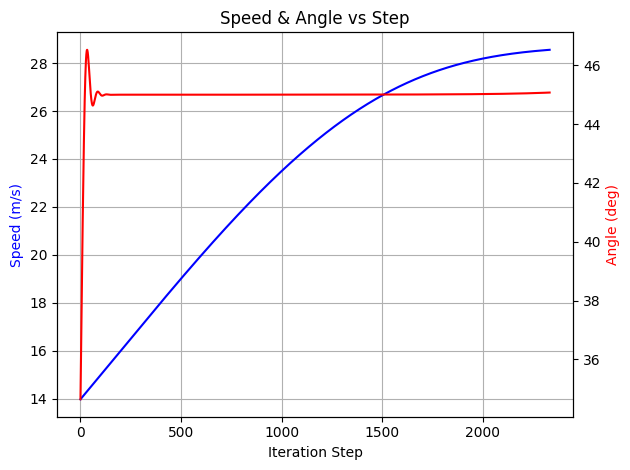

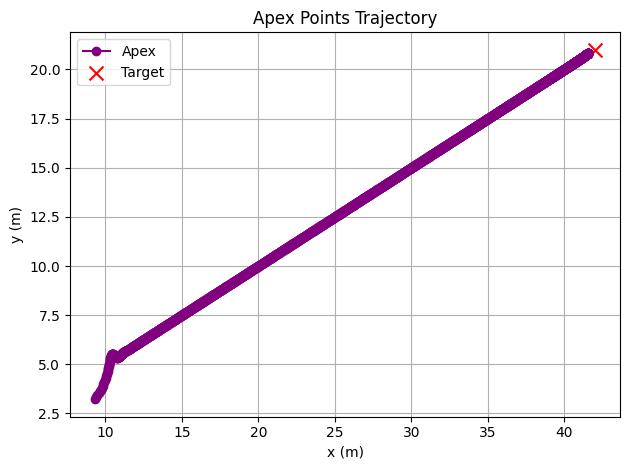

In [70]:
class ProjectileTargetOptimiserMulti:
    def __init__(self, target_x: float, target_y: float, gravity: float = 9.81,
                 w_target: float = 1.0, w_time: float = 0.05):
        self.target_x = target_x
        self.target_y = target_y
        print(f"Target: ({self.target_x}, {self.target_y})")
        self.g = gravity
        self.w_target = w_target
        self.w_time = w_time

        self.velocity = torch.tensor(torch.rand(1).item() * 50, requires_grad=True)
        self.angle = torch.tensor(torch.rand(1).item() * (np.pi/2 - 0.01) + 0.01, requires_grad=True)

        self.history_steps = []
        self.history_v = []
        self.history_angle = []
        self.history_apex = []

    def endpoint(self) -> Optional[torch.Tensor]:
        v, θ, g = self.velocity, self.angle, self.g
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y

        disc = torch.clamp(b**2 - 4*a*c, min=1e-6)
        sqrt_disc = torch.sqrt(disc)
        t1 = (-b + sqrt_disc) / (2*a)
        t2 = (-b - sqrt_disc) / (2*a)

        t_apex = b / g
        candidates = [t for t in [t1, t2] if t > 0 and t < t_apex]
        if not candidates:
            return None

        t_hit = min(candidates)
        x_hit = v * torch.cos(θ) * t_hit
        return x_hit

    def total_flight_time(self) -> torch.Tensor:
        return 2*self.velocity*torch.sin(self.angle)/self.g

    def loss(self) -> torch.Tensor:
        x_hit = self.endpoint()
        if x_hit is None:
            t_apex = self.velocity*torch.sin(self.angle)/self.g
            x_apex = self.velocity*torch.cos(self.angle)*t_apex
            target_loss = (x_apex - self.target_x)**2
        else:
            target_loss = (x_hit - self.target_x)**2
        return self.w_target*target_loss - self.w_time*self.total_flight_time()

    def trajectory(self, n_points: int = 501) -> Tuple[np.ndarray, np.ndarray, Tuple[float,float]]:
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        t_apex = v*np.sin(θ)/g
        x_apex = v*np.cos(θ)*t_apex
        y_apex = v*np.sin(θ)*t_apex - 0.5*g*t_apex**2
        return x, y, (x_apex, y_apex)

    def optimise_and_gif(
        self,
        steps: int = 1000000,
        lr: float = 0.01,
        gif_name: str = "optimisation_multi_final.gif",
        save_every: int = 20,
        early_stop_tol: float = 1e-9
    ):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []
        sampled_trajectories = []
        xlim = (0, 1.5*self.target_x)
        ylim = (0, 1.5*self.target_y)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            self.velocity.data.clamp_(0.1, 100.0)
            self.angle.data.clamp_(-np.pi/2 + 0.01, np.pi/2-0.01)

            v = self.velocity.item()
            θ = self.angle.item()
            v_x = v * np.cos(θ)
            v_y = v * np.sin(θ)
            x, y, apex = self.trajectory()

            # Store step history
            self.history_steps.append(step)
            self.history_v.append(v)
            self.history_angle.append(θ*180/np.pi)
            self.history_apex.append(apex)

            if L.item() < early_stop_tol:
                print(f"Converged at step {step}")
                break

            if step % save_every == 0:
                print(f"Step {step}: v={v:.2f}, angle={θ*180/np.pi:.2f} deg, "
                      f"v_x={v_x:.2f}, v_y={v_y:.2f}")
                sampled_trajectories.append((x, y, apex))

                fig, ax = plt.subplots()
                n_traj = len(sampled_trajectories)
                cmap = plt.get_cmap("Blues")

                for i, (xi, yi, ai) in enumerate(sampled_trajectories[:-1]):
                    alpha = 0.3 + 0.7*(i/(n_traj-1)) if n_traj > 1 else 0.5
                    ax.plot(xi, yi, color=cmap(alpha), linewidth=1)
                    ax.scatter(*ai, color="grey", s=20, alpha=0.5)

                x, y, apex = sampled_trajectories[-1]
                ax.plot(x, y, color="black", linewidth=2, label=f"Step {step}")
                ax.scatter(*apex, color="orange", s=40, label="Apex")
                ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")

                info_text = f"v={v:.2f} m/s\nangle={θ*180/np.pi:.2f}°\nv_x={v_x:.2f}\nv_y={v_y:.2f}"
                ax.text(0.02, 0.95, info_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                ax.set_title(f"Trajectories up to step {step}")
                fig.tight_layout()
                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(frame)
                plt.close(fig)

        # Save GIF of final trajectory
        x_final, y_final, _ = self.trajectory()
        n_points = len(x_final)
        step_size = max(1, n_points // 100)
        for i in range(0, n_points, step_size):
            fig, ax = plt.subplots()
            for (xi, yi, _) in sampled_trajectories:
                ax.plot(xi, yi, color='blue', alpha=0.3, linewidth=1)
            ax.plot(x_final[:i+1], y_final[:i+1], color='green', linewidth=4)
            ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100)
            ax.set_xlim(0, 1.5*self.target_x)
            ax.set_ylim(0, 1.5*self.target_y)
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=5)
        print(f"Saved {gif_name}")

        # --- New plots in terminal ---

        # 1. Speed & Angle vs iteration
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.history_steps, self.history_v, 'b-', label='Speed (m/s)')
        ax2.plot(self.history_steps, self.history_angle, 'r-', label='Angle (deg)')

        ax1.set_xlabel('Iteration Step')
        ax1.set_ylabel('Speed (m/s)', color='b')
        ax2.set_ylabel('Angle (deg)', color='r')
        ax1.set_title("Speed & Angle vs Step")
        ax1.grid(True)
        fig.tight_layout()
        plt.show()

        # 2. Apex points trajectory
        fig, ax = plt.subplots()
        apex_x = [ap[0] for ap in self.history_apex]
        apex_y = [ap[1] for ap in self.history_apex]
        ax.plot(apex_x, apex_y, 'o-', color='purple', label='Apex')
        ax.scatter(self.target_x, self.target_y, c='red', marker='x', s=100, label='Target')
        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.set_title('Apex Points Trajectory')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()


# Example usage
if __name__ == "__main__":
    opt = ProjectileTargetOptimiserMulti(
        target_x=np.random.randint(0,100),
        target_y=np.random.randint(0,100)
    )
    opt.optimise_and_gif()

Target: (42, 79)
Step 0: v=35.21, angle=84.40 deg, v_x=3.44, v_y=35.04
Step 20: v=35.28, angle=63.97 deg, v_x=15.48, v_y=31.70


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\1001257249.py:128: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 40: v=34.85, angle=69.62 deg, v_x=12.14, v_y=32.67
Step 60: v=34.81, angle=68.82 deg, v_x=12.57, v_y=32.46
Step 80: v=34.81, angle=68.30 deg, v_x=12.87, v_y=32.35
Step 100: v=34.80, angle=68.57 deg, v_x=12.72, v_y=32.40
Step 120: v=34.80, angle=68.60 deg, v_x=12.70, v_y=32.40
Step 140: v=34.80, angle=68.57 deg, v_x=12.71, v_y=32.40
Step 160: v=34.80, angle=68.57 deg, v_x=12.72, v_y=32.40
Step 180: v=34.81, angle=68.57 deg, v_x=12.72, v_y=32.40
Step 200: v=34.81, angle=68.57 deg, v_x=12.72, v_y=32.40
Step 220: v=34.81, angle=68.57 deg, v_x=12.72, v_y=32.40
Step 240: v=34.81, angle=68.57 deg, v_x=12.72, v_y=32.40
Step 260: v=34.81, angle=68.57 deg, v_x=12.72, v_y=32.40
Step 280: v=34.81, angle=68.58 deg, v_x=12.72, v_y=32.40
Step 300: v=34.81, angle=68.58 deg, v_x=12.71, v_y=32.41
Step 320: v=34.81, angle=68.58 deg, v_x=12.71, v_y=32.41
Step 340: v=34.81, angle=68.58 deg, v_x=12.71, v_y=32.41
Step 360: v=34.81, angle=68.58 deg, v_x=12.71, v_y=32.41
Step 380: v=34.81, angle=68.58 deg

KeyboardInterrupt: 

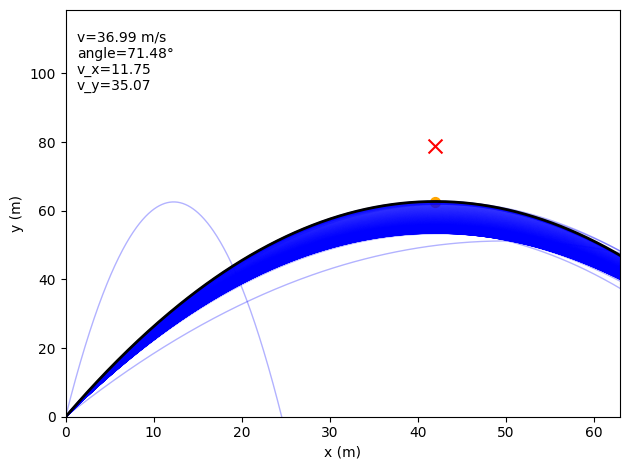

In [88]:
class ProjectileTargetOptimiserMulti:
    def __init__(self, target_x: float, target_y: float, gravity: float = 9.81,
                 w_target: float = 1.0, w_time: float = 0.05, angle_penalty_strength: float = 10.0):
        self.target_x = target_x
        self.target_y = target_y
        print(f"Target: ({self.target_x}, {self.target_y})")
        self.g = gravity
        self.w_target = w_target
        self.w_time = w_time
        self.angle_penalty_strength = angle_penalty_strength

        self.velocity = torch.tensor(torch.rand(1).item() * 50, requires_grad=True)
        self.angle = torch.tensor(torch.rand(1).item() * (np.pi/2 - 0.01) + 0.01, requires_grad=True)

        self.history_steps = []
        self.history_v = []
        self.history_angle = []
        self.history_nearest_point = []

    def endpoint(self) -> Optional[torch.Tensor]:
        v, θ, g = self.velocity, self.angle, self.g
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y
        disc = torch.clamp(b**2 - 4*a*c, min=1e-6)
        sqrt_disc = torch.sqrt(disc)
        t1 = (-b + sqrt_disc) / (2*a)
        t2 = (-b - sqrt_disc) / (2*a)
        t_apex = b / g
        candidates = [t for t in [t1, t2] if t > 0 and t < t_apex]
        if not candidates:
            return None
        t_hit = min(candidates)
        x_hit = v * torch.cos(θ) * t_hit
        return x_hit

    def total_flight_time(self) -> torch.Tensor:
        return 2*self.velocity*torch.sin(self.angle)/self.g

    def trajectory(self, n_points: int = 501) -> Tuple[np.ndarray, np.ndarray]:
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        return x, y

    def loss(self) -> torch.Tensor:
        x_hit = self.endpoint()
        if x_hit is None:
            t_apex = self.velocity*torch.sin(self.angle)/self.g
            x_apex = self.velocity*torch.cos(self.angle)*t_apex
            target_loss = (x_apex - self.target_x)**2
        else:
            target_loss = (x_hit - self.target_x)**2

        # Uniform penalty for angles between 40° and 50°
        θ_deg = self.angle * 180 / np.pi
        angle_penalty = torch.tensor(0.0)
        if 40 <= θ_deg <= 50:
            angle_penalty = self.angle_penalty_strength

        return self.w_target*target_loss - self.w_time*self.total_flight_time() + angle_penalty

    def optimise_and_gif(
        self,
        steps: int = 100000,
        lr: float = 0.05,
        gif_name: str = "optimisation_multi_final.gif",
        save_every: int = 20,
        early_stop_tol: float = 1e-7
    ):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []
        sampled_trajectories = []
        xlim = (0, 1.5*self.target_x)
        ylim = (0, 1.5*self.target_y)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            self.velocity.data.clamp_(0.1, 100.0)
            self.angle.data.clamp_(-np.pi/2 + 0.01, np.pi/2-0.01)

            v = self.velocity.item()
            θ = self.angle.item()
            x, y = self.trajectory()

            # Store history
            self.history_steps.append(step)
            self.history_v.append(v)
            self.history_angle.append(θ*180/np.pi)

            # Nearest point to target
            distances = np.sqrt((x - self.target_x)**2 + (y - self.target_y)**2)
            nearest_idx = np.argmin(distances)
            self.history_nearest_point.append((x[nearest_idx], y[nearest_idx]))

            if step % save_every == 0:
                print(f"Step {step}: v={v:.2f}, angle={θ*180/np.pi:.2f} deg, "
                      f"v_x={v*np.cos(θ):.2f}, v_y={v*np.sin(θ):.2f}")
                sampled_trajectories.append((x, y))

                # Plot GIF frame
                fig, ax = plt.subplots()
                for xi, yi in sampled_trajectories[:-1]:
                    ax.plot(xi, yi, color='blue', alpha=0.3, linewidth=1)
                ax.plot(x, y, color='black', linewidth=2, label=f"Step {step}")

                nearest_point = self.history_nearest_point[-1]
                ax.scatter(*nearest_point, color='orange', s=50, label='Nearest Point')
                ax.scatter(self.target_x, self.target_y, c='red', marker='x', s=100, label='Target')

                info_text = f"v={v:.2f} m/s\nangle={θ*180/np.pi:.2f}°\nv_x={v*np.cos(θ):.2f}\nv_y={v*np.sin(θ):.2f}"
                ax.text(0.02, 0.95, info_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                fig.tight_layout()
                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(frame)
                plt.close(fig)

        # Final trajectory frame (green)
        x_final, y_final = self.trajectory()
        n_points = len(x_final)
        step_size = max(1, n_points // 100)
        for i in range(0, n_points, step_size):
            fig, ax = plt.subplots()
            for xi, yi in sampled_trajectories:
                ax.plot(xi, yi, color='blue', alpha=0.3, linewidth=1)
            ax.plot(x_final[:i+1], y_final[:i+1], color='green', linewidth=4)
            ax.scatter(self.target_x, self.target_y, c='red', marker='x', s=100)
            distances = np.sqrt((x_final[:i+1] - self.target_x)**2 + (y_final[:i+1] - self.target_y)**2)
            nearest_idx = np.argmin(distances)
            ax.scatter(x_final[nearest_idx], y_final[nearest_idx], color='orange', s=50, label='Nearest Point')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=5)
        print(f"Saved {gif_name}")

        # --- Terminal plots ---

        # 1. Speed & Angle vs iteration
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.history_steps, self.history_v, 'b-', label='Speed (m/s)')
        ax2.plot(self.history_steps, self.history_angle, 'r-', label='Angle (deg)')
        ax1.set_xlabel('Iteration Step')
        ax1.set_ylabel('Speed (m/s)', color='b')
        ax2.set_ylabel('Angle (deg)', color='r')
        ax1.set_title("Speed & Angle vs Step")
        ax1.grid(True)
        plt.show()

        # 2. Nearest point to target trajectory
        fig, ax = plt.subplots()
        nearest_x = [pt[0] for pt in self.history_nearest_point]
        nearest_y = [pt[1] for pt in self.history_nearest_point]
        ax.plot(nearest_x, nearest_y, 'o-', color='purple', label='Nearest point to target')
        ax.scatter(self.target_x, self.target_y, c='red', marker='x', s=100, label='Target')
        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.set_title('Trajectory Point Nearest Target Over Iterations')
        ax.grid(True)
        ax.legend()
        plt.show()

# Example usage
if __name__ == "__main__":
    opt = ProjectileTargetOptimiserMulti(
        target_x=np.random.randint(0,100),
        target_y=np.random.randint(0,100)
    )
    opt.optimise_and_gif()

Target: (63, 80)
Step 0: v=27.98, angle=27.74 deg, v_x=24.77, v_y=13.02
Loss: 1257.8823


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\1813038963.py:148: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 100: v=34.81, angle=45.00 deg, v_x=24.61, v_y=24.61
Loss: 101.5016
Step 200: v=35.16, angle=45.35 deg, v_x=24.71, v_y=25.01
Loss: 99.7450
Converged at step 244


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\1813038963.py:167: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved optimisation_multi_final.gif


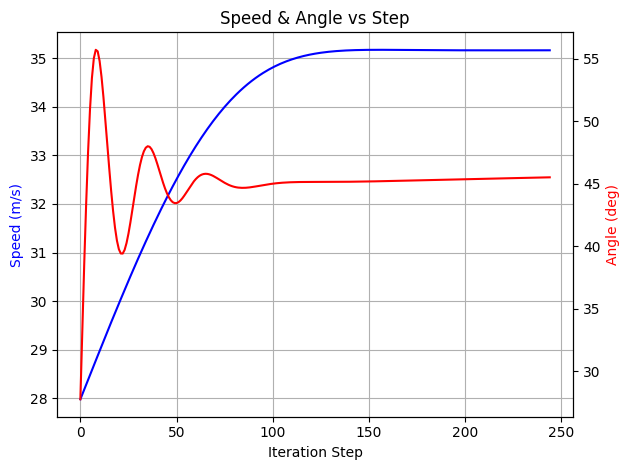

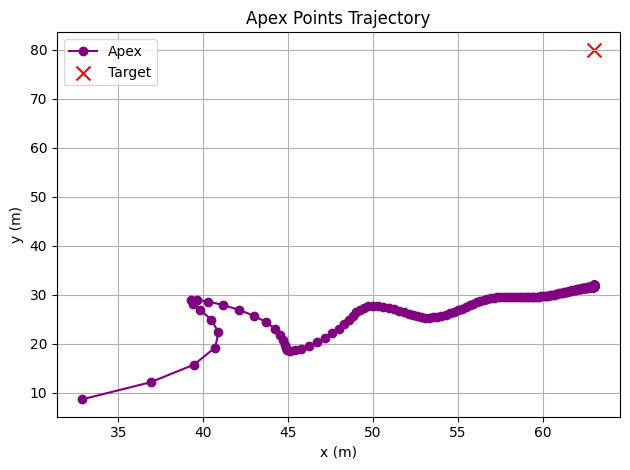

In [81]:
class ProjectileTargetOptimiserMulti:
    def __init__(self, target_x: float, target_y: float, gravity: float = 9.81,
                 w_target: float = 1.0, w_time: float = 0.05,
                 angle_penalty_strength: float = 100.0):
        self.target_x = target_x
        self.target_y = target_y
        print(f"Target: ({self.target_x}, {self.target_y})")
        self.g = gravity
        self.w_target = w_target
        self.w_time = w_time
        self.angle_penalty_strength = angle_penalty_strength
        self.velocity = torch.tensor(torch.rand(1).item() * 50, requires_grad=True)
        self.angle = torch.tensor(torch.rand(1).item() * (np.pi/2 - 0.01) + 0.01, requires_grad=True)

        self.history_steps = []
        self.history_v = []
        self.history_angle = []
        self.history_apex = []

    def endpoint(self) -> Optional[torch.Tensor]:
        v, θ, g = self.velocity, self.angle, self.g
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y

        disc = torch.clamp(b**2 - 4*a*c, min=1e-6)
        sqrt_disc = torch.sqrt(disc)
        t1 = (-b + sqrt_disc) / (2*a)
        t2 = (-b - sqrt_disc) / (2*a)

        t_apex = b / g
        candidates = [t for t in [t1, t2] if t > 0 and t < t_apex]
        if not candidates:
            return None

        t_hit = min(candidates)
        x_hit = v * torch.cos(θ) * t_hit
        return x_hit

    def total_flight_time(self) -> torch.Tensor:
        return 2*self.velocity*torch.sin(self.angle)/self.g

    def loss(self) -> torch.Tensor:
        l = 0
        x_hit = self.endpoint()
        if x_hit is None:
            t_apex = self.velocity*torch.sin(self.angle)/self.g
            x_apex = self.velocity*torch.cos(self.angle)*t_apex
            target_loss = (x_apex - self.target_x)**2
        else:
            target_loss = (x_hit - self.target_x)**2

        # Uniform penalty for angles between 40° and 50°
        θ_deg = self.angle * 180 / np.pi
        angle_penalty = torch.tensor(0.0)
        if 44.5 <= θ_deg <= 45.5:
            angle_penalty = self.angle_penalty_strength
        else:
            angle_penalty = 0.0

        l+=angle_penalty
        l+=self.w_target*target_loss - self.w_time*self.total_flight_time()
        return l


    def trajectory(self, n_points: int = 501) -> Tuple[np.ndarray, np.ndarray, Tuple[float,float]]:
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        t_apex = v*np.sin(θ)/g
        x_apex = v*np.cos(θ)*t_apex
        y_apex = v*np.sin(θ)*t_apex - 0.5*g*t_apex**2
        return x, y, (x_apex, y_apex)

    def optimise_and_gif(
        self,
        steps: int = 100000,
        lr: float = 0.1,
        gif_name: str = "optimisation_multi_final.gif",
        save_every: int = 100,
        early_stop_tol: float = 1e-8
    ):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []
        sampled_trajectories = []
        xlim = (0, 1.5*self.target_x)
        ylim = (0, 1.5*self.target_y)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            self.velocity.data.clamp_(0.1, 100.0)
            self.angle.data.clamp_(-np.pi/2 + 0.01, np.pi/2-0.01)

            v = self.velocity.item()
            θ = self.angle.item()
            v_x = v * np.cos(θ)
            v_y = v * np.sin(θ)
            x, y, apex = self.trajectory()

            # Store step history
            self.history_steps.append(step)
            self.history_v.append(v)
            self.history_angle.append(θ*180/np.pi)
            self.history_apex.append(apex)

            if L.item() < early_stop_tol:
                print(f"Converged at step {step}")
                break

            if step % save_every == 0:
                print(f"Step {step}: v={v:.2f}, angle={θ*180/np.pi:.2f} deg, "
                      f"v_x={v_x:.2f}, v_y={v_y:.2f}")
                print(f"Loss: {L.item():.4f}")
                sampled_trajectories.append((x, y, apex))

                fig, ax = plt.subplots()
                n_traj = len(sampled_trajectories)
                cmap = plt.get_cmap("Blues")

                for i, (xi, yi, ai) in enumerate(sampled_trajectories[:-1]):
                    alpha = 0.3 + 0.7*(i/(n_traj-1)) if n_traj > 1 else 0.5
                    ax.plot(xi, yi, color=cmap(alpha), linewidth=1)
                    ax.scatter(*ai, color="grey", s=20, alpha=0.5)

                x, y, apex = sampled_trajectories[-1]
                ax.plot(x, y, color="black", linewidth=2, label=f"Step {step}")
                ax.scatter(*apex, color="orange", s=40, label="Apex")
                ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")

                info_text = f"v={v:.2f} m/s\nangle={θ*180/np.pi:.2f}°\nv_x={v_x:.2f}\nv_y={v_y:.2f}"
                ax.text(0.02, 0.95, info_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                ax.set_title(f"Trajectories up to step {step}")
                fig.tight_layout()
                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(frame)
                plt.close(fig)

        # Save GIF of final trajectory
        x_final, y_final, _ = self.trajectory()
        n_points = len(x_final)
        step_size = max(1, n_points // 100)
        for i in range(0, n_points, step_size):
            fig, ax = plt.subplots()
            for (xi, yi, _) in sampled_trajectories:
                ax.plot(xi, yi, color='blue', alpha=0.3, linewidth=1)
            ax.plot(x_final[:i+1], y_final[:i+1], color='green', linewidth=4)
            ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100)
            ax.set_xlim(0, 1.5*self.target_x)
            ax.set_ylim(0, 1.5*self.target_y)
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=5)
        print(f"Saved {gif_name}")

        # --- New plots in terminal ---

        # 1. Speed & Angle vs iteration
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.history_steps, self.history_v, 'b-', label='Speed (m/s)')
        ax2.plot(self.history_steps, self.history_angle, 'r-', label='Angle (deg)')

        ax1.set_xlabel('Iteration Step')
        ax1.set_ylabel('Speed (m/s)', color='b')
        ax2.set_ylabel('Angle (deg)', color='r')
        ax1.set_title("Speed & Angle vs Step")
        ax1.grid(True)
        fig.tight_layout()
        plt.show()

        # 2. Apex points trajectory
        fig, ax = plt.subplots()
        apex_x = [ap[0] for ap in self.history_apex]
        apex_y = [ap[1] for ap in self.history_apex]
        ax.plot(apex_x, apex_y, 'o-', color='purple', label='Apex')
        ax.scatter(self.target_x, self.target_y, c='red', marker='x', s=100, label='Target')
        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.set_title('Apex Points Trajectory')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()


# Example usage
if __name__ == "__main__":
    opt = ProjectileTargetOptimiserMulti(
        target_x=np.random.randint(0,100),
        target_y=np.random.randint(0,100)
    )
    opt.optimise_and_gif()

Target: (23, 94)
Step 0: v=32.87, angle=85.28 deg, v_x=2.70, v_y=32.76
Step 20: v=33.07, angle=89.43 deg, v_x=0.33, v_y=33.07


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\3732456752.py:131: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 40: v=33.27, angle=89.43 deg, v_x=0.33, v_y=33.27
Step 60: v=33.47, angle=89.43 deg, v_x=0.33, v_y=33.47
Step 80: v=33.67, angle=89.43 deg, v_x=0.34, v_y=33.67
Step 100: v=33.87, angle=89.43 deg, v_x=0.34, v_y=33.87
Step 120: v=34.07, angle=89.43 deg, v_x=0.34, v_y=34.07
Step 140: v=34.27, angle=89.43 deg, v_x=0.34, v_y=34.27
Step 160: v=34.47, angle=89.43 deg, v_x=0.34, v_y=34.47
Step 180: v=34.67, angle=89.43 deg, v_x=0.35, v_y=34.67
Step 200: v=34.87, angle=89.43 deg, v_x=0.35, v_y=34.87
Step 220: v=35.07, angle=89.43 deg, v_x=0.35, v_y=35.07
Step 240: v=35.27, angle=89.43 deg, v_x=0.35, v_y=35.27
Step 260: v=35.47, angle=89.43 deg, v_x=0.35, v_y=35.47
Step 280: v=35.67, angle=89.43 deg, v_x=0.36, v_y=35.67
Step 300: v=35.87, angle=89.43 deg, v_x=0.36, v_y=35.87
Step 320: v=36.07, angle=89.43 deg, v_x=0.36, v_y=36.07
Step 340: v=36.27, angle=89.43 deg, v_x=0.36, v_y=36.27
Step 360: v=36.47, angle=89.43 deg, v_x=0.36, v_y=36.47
Step 380: v=36.67, angle=89.43 deg, v_x=0.37, v_y=3

KeyboardInterrupt: 

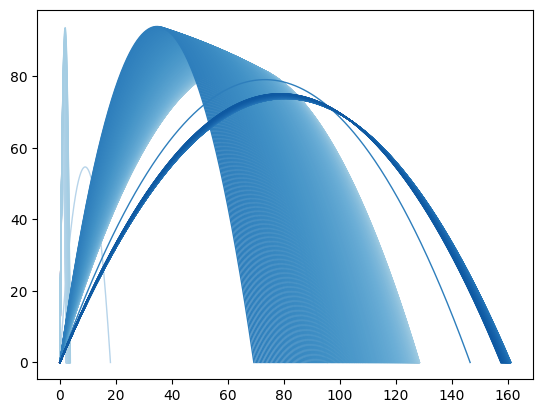

In [84]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from typing import Tuple, Optional

class ProjectileTargetOptimiserMulti:
    def __init__(self, target_x: float, target_y: float, gravity: float = 9.81,
                 w_target: float = 1.0, w_time: float = 0.05, w_angle_penalty: float = 50.0):
        self.target_x = target_x
        self.target_y = target_y
        print(f"Target: ({self.target_x}, {self.target_y})")
        self.g = gravity
        self.w_target = w_target
        self.w_time = w_time
        self.w_angle_penalty = w_angle_penalty

        self.velocity = torch.tensor(torch.rand(1).item() * 50, requires_grad=True)
        self.angle = torch.tensor(torch.rand(1).item() * (np.pi/2 - 0.01) + 0.01, requires_grad=True)

        # history
        self.history_steps = []
        self.history_v = []
        self.history_angle = []
        self.history_nearest_point = []

    def trajectory(self, n_points: int = 501) -> Tuple[np.ndarray, np.ndarray]:
        """Compute full projectile trajectory."""
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2 * v * np.sin(θ) / g
        t = np.linspace(0, t_flight, n_points)
        x = v * np.cos(θ) * t
        y = v * np.sin(θ) * t - 0.5 * g * t**2
        return x, y

    def nearest_point_to_target(self, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
        """Find point on trajectory closest to target."""
        distances = np.sqrt((x - self.target_x)**2 + (y - self.target_y)**2)
        idx = np.argmin(distances)
        return x[idx], y[idx]

    def endpoint(self) -> torch.Tensor:
        """Compute x at target_y plane (simplified quadratic solution)."""
        v, θ, g = self.velocity, self.angle, self.g
        a = -0.5 * g
        b = v * torch.sin(θ)
        c = -self.target_y
        disc = b**2 - 4*a*c
        if disc < 0:
            return torch.tensor(float("inf"))
        t1 = (-b + torch.sqrt(disc)) / (2*a)
        t2 = (-b - torch.sqrt(disc)) / (2*a)
        t_hit = torch.max(t1, t2)
        return v * torch.cos(θ) * t_hit

    def total_flight_time(self) -> torch.Tensor:
        return 2*self.velocity*torch.sin(self.angle)/self.g

    def loss(self) -> torch.Tensor:
        x_hit = self.endpoint()
        target_loss = (x_hit - self.target_x)**2

        # uniform penalty for angles between 40 and 50 degrees
        angle_deg = self.angle * 180/np.pi
        angle_penalty = torch.where((angle_deg >= 40) & (angle_deg <= 50),
                                    torch.tensor(self.w_angle_penalty, dtype=torch.float32),
                                    torch.tensor(0.0, dtype=torch.float32))
        return self.w_target*target_loss - self.w_time*self.total_flight_time() + angle_penalty

    def optimise_and_gif(self, steps: int = 100000, lr: float = 0.01,
                         gif_name: str = "optimisation_multi_final.gif",
                         save_every: int = 20, early_stop_tol: float = 1e-9):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []
        sampled_trajectories = []

        xlim = (0, 1.5*self.target_x)
        ylim = (0, 1.5*self.target_y)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            self.velocity.data.clamp_(0.1, 100.0)
            self.angle.data.clamp_(-np.pi/2 + 0.01, np.pi/2 - 0.01)

            v = self.velocity.item()
            θ = self.angle.item()
            v_x = v * np.cos(θ)
            v_y = v * np.sin(θ)
            x, y = self.trajectory()
            nearest_pt = self.nearest_point_to_target(x, y)

            # store history
            self.history_steps.append(step)
            self.history_v.append(v)
            self.history_angle.append(θ*180/np.pi)
            self.history_nearest_point.append(nearest_pt)

            if L.item() < early_stop_tol:
                print(f"Converged at step {step}")
                break

            if step % save_every == 0:
                print(f"Step {step}: v={v:.2f}, angle={θ*180/np.pi:.2f} deg, "
                      f"v_x={v_x:.2f}, v_y={v_y:.2f}")
                sampled_trajectories.append((x, y))

                # plot current trajectories
                fig, ax = plt.subplots()
                n_traj = len(sampled_trajectories)
                cmap = plt.get_cmap("Blues")
                for i, (xi, yi) in enumerate(sampled_trajectories[:-1]):
                    alpha = 0.3 + 0.7*(i/(n_traj-1)) if n_traj > 1 else 0.5
                    ax.plot(xi, yi, color=cmap(alpha), linewidth=1)
                ax.plot(x, y, color="black", linewidth=2, label=f"Step {step}")
                ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100)
                info_text = f"v={v:.2f} m/s\nangle={θ*180/np.pi:.2f}°\nv_x={v_x:.2f}\nv_y={v_y:.2f}"
                ax.text(0.02, 0.95, info_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                fig.tight_layout()
                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(frame)
                plt.close(fig)

        # final trajectory green line
        x_final, y_final = self.trajectory()
        n_points = len(x_final)
        step_size = max(1, n_points//100)
        for i in range(0, n_points, step_size):
            fig, ax = plt.subplots()
            for (xi, yi) in sampled_trajectories:
                ax.plot(xi, yi, color='blue', alpha=0.3, linewidth=1)
            ax.plot(x_final[:i+1], y_final[:i+1], color='green', linewidth=4)
            ax.scatter(self.target_x, self.target_y, c='red', marker='x', s=100)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=5)
        print(f"Saved {gif_name}")

        # --- Terminal plots ---
        # Speed & angle
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.history_steps, self.history_v, 'b-', label='Speed (m/s)')
        ax2.plot(self.history_steps, self.history_angle, 'r-', label='Angle (deg)')
        ax1.set_xlabel('Iteration Step')
        ax1.set_ylabel('Speed (m/s)', color='b')
        ax2.set_ylabel('Angle (deg)', color='r')
        fig.tight_layout()
        plt.show()

        # Nearest point to target
        fig, ax = plt.subplots()
        nearest_x = [pt[0] for pt in self.history_nearest_point]
        nearest_y = [pt[1] for pt in self.history_nearest_point]
        ax.plot(nearest_x, nearest_y, 'o-', color='purple', label='Nearest point to target')
        ax.scatter(self.target_x, self.target_y, c='red', marker='x', s=100, label='Target')
        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.legend()
        plt.tight_layout()
        plt.show()


# Example usage
if __name__ == "__main__":
    opt = ProjectileTargetOptimiserMulti(
        target_x=np.random.randint(0,100),
        target_y=np.random.randint(0,100)
    )
    opt.optimise_and_gif()

Target: (67, 49)
Step 0: v=18.81, angle=14.22 deg, v_x=18.24, v_y=4.62, min_dist=71.06
Step 25: v=19.48, angle=49.71 deg, v_x=12.60, v_y=14.86, min_dist=55.48


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\881550424.py:152: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 50: v=20.19, angle=50.73 deg, v_x=12.78, v_y=15.63, min_dist=53.58
Step 75: v=20.87, angle=52.12 deg, v_x=12.81, v_y=16.47, min_dist=51.77
Step 100: v=21.53, angle=52.08 deg, v_x=13.23, v_y=16.98, min_dist=49.96
Step 125: v=22.17, angle=52.78 deg, v_x=13.41, v_y=17.66, min_dist=48.16
Step 150: v=22.80, angle=53.34 deg, v_x=13.61, v_y=18.29, min_dist=46.35
Step 175: v=23.42, angle=53.84 deg, v_x=13.82, v_y=18.91, min_dist=44.53
Step 200: v=24.03, angle=54.35 deg, v_x=14.01, v_y=19.53, min_dist=42.71
Step 225: v=24.63, angle=54.84 deg, v_x=14.19, v_y=20.14, min_dist=40.88
Step 250: v=25.22, angle=55.31 deg, v_x=14.36, v_y=20.74, min_dist=39.06
Step 275: v=25.80, angle=55.79 deg, v_x=14.51, v_y=21.34, min_dist=37.24
Step 300: v=26.37, angle=56.23 deg, v_x=14.66, v_y=21.92, min_dist=35.42
Step 325: v=26.92, angle=56.65 deg, v_x=14.80, v_y=22.48, min_dist=33.62
Step 350: v=27.46, angle=57.05 deg, v_x=14.93, v_y=23.04, min_dist=31.84
Step 375: v=27.98, angle=57.47 deg, v_x=15.05, v_y=23

C:\Users\jones\AppData\Local\Temp\ipykernel_61084\881550424.py:181: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved optimisation_multi_final.gif


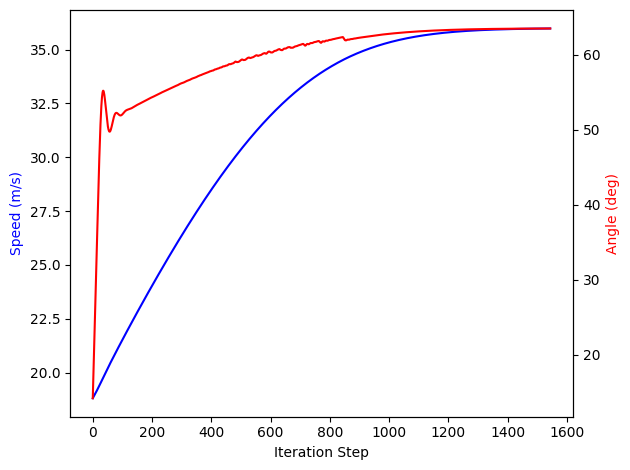

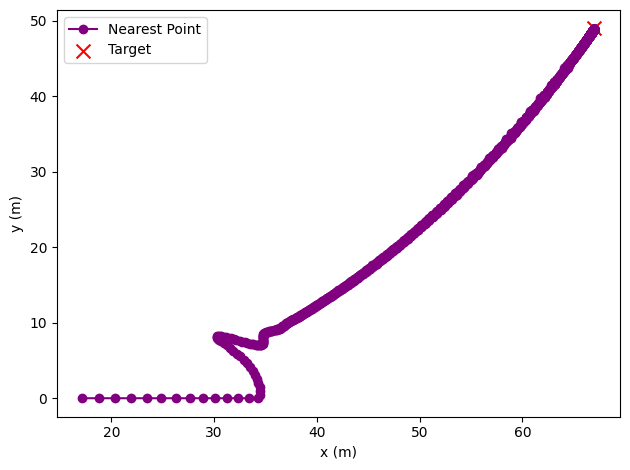

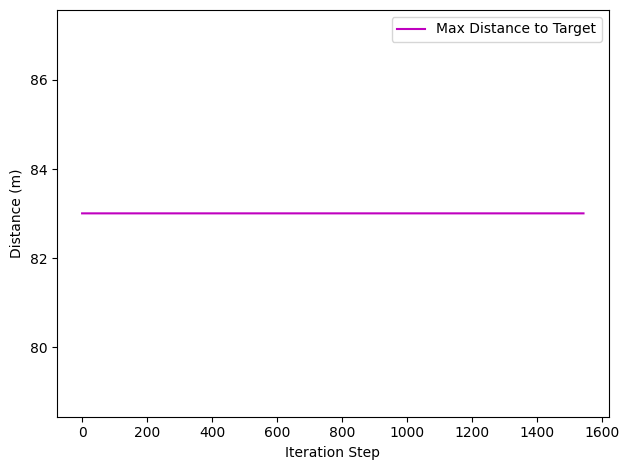

In [95]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from typing import Tuple, Optional

class ProjectileTargetOptimiserMulti:
    def __init__(self, target_x: float, target_y: float, gravity: float = 9.81,
                 w_target: float = 1.0, w_time: float = 0.05):
        self.target_x = target_x
        self.target_y = target_y
        print(f"Target: ({self.target_x}, {self.target_y})")
        self.g = gravity
        self.w_target = w_target
        self.w_time = w_time

        # Initial guesses
        self.velocity = torch.tensor(torch.rand(1).item()*50, requires_grad=True)
        self.angle = torch.tensor(torch.rand(1).item()*np.pi - (np.pi/2) + 0.01, requires_grad=True)

        # History tracking
        self.history_steps = []
        self.history_v = []
        self.history_angle = []
        self.history_apex = []
        self.history_nearest_point = []
        self.history_min_dist = []
        self.history_max_dist = []

    def trajectory(self, n_points: int = 501) -> Tuple[np.ndarray, np.ndarray, Tuple[float,float]]:
        """Return full trajectory and apex"""
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        t_apex = v*np.sin(θ)/g
        x_apex = v*np.cos(θ)*t_apex
        y_apex = v*np.sin(θ)*t_apex - 0.5*g*t_apex**2
        return x, y, (x_apex, y_apex)

    def nearest_point_to_target(self, x: np.ndarray, y: np.ndarray) -> Tuple[float,float]:
        """Return point on trajectory nearest to target"""
        d2 = (x - self.target_x)**2 + (y - self.target_y)**2
        idx = np.argmin(d2)
        return x[idx], y[idx]

    def max_distance_to_target(self, x: np.ndarray, y: np.ndarray) -> float:
        return float(np.max(np.sqrt((x - self.target_x)**2 + (y - self.target_y)**2)))

    def loss(self) -> torch.Tensor:
        v, θ = self.velocity, self.angle

        # Full trajectory for max distance
        n_points = 501
        t_flight = 2*v*torch.sin(θ)/self.g
        t = torch.linspace(0, t_flight, n_points)
        x = v*torch.cos(θ)*t
        y = v*torch.sin(θ)*t - 0.5*self.g*t**2

        # Distance to target
        d2 = (x - self.target_x)**2 + (y - self.target_y)**2
        min_dist = torch.min(torch.sqrt(d2))
        max_dist = torch.max(torch.sqrt(d2))
        self.current_max_dist = max_dist.item()
        self.current_min_dist = min_dist.item()

        # Target loss = squared distance at closest point
        target_loss = 100*min_dist**2

        # Uniform penalty for angles between 40–50 degrees
        angle_deg = θ*180/np.pi
        penalty = 0.0
        if 44.5 <= angle_deg <= 45.5:
            penalty = 10  # uniform penalty

        # Multi-objective: target + flight time + angle penalty
        total_loss = self.w_target*target_loss - self.w_time*(2*v*torch.sin(θ)/self.g) + penalty
        return total_loss

    def optimise_and_gif(
        self,
        steps: int = 5000,
        lr: float = 0.025,
        gif_name: str = "optimisation_multi_final.gif",
        save_every: int = 25,
        early_stop_tol: float = 1e-9
    ):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []
        sampled_trajectories = []
        xlim = (0, 1.5*self.target_x)
        ylim = (0, 1.5*self.target_y)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            # Clamp values
            self.velocity.data.clamp_(0.1, 100.0)
            self.angle.data.clamp_(-np.pi/2 + 0.01, np.pi/2 - 0.01)

            v = self.velocity.item()
            θ = self.angle.item()
            v_x = v * np.cos(θ)
            v_y = v * np.sin(θ)
            x, y, apex = self.trajectory()

            nearest_point = self.nearest_point_to_target(x, y)

            # Store history
            self.history_steps.append(step)
            self.history_v.append(v)
            self.history_angle.append(θ*180/np.pi)
            self.history_apex.append(apex)
            self.history_nearest_point.append(nearest_point)
            self.history_min_dist.append(self.current_min_dist)
            self.history_max_dist.append(self.current_max_dist)

            if step % save_every == 0:
                print(f"Step {step}: v={v:.2f}, angle={θ*180/np.pi:.2f} deg, "
                      f"v_x={v_x:.2f}, v_y={v_y:.2f}, min_dist={self.history_min_dist[-1]:.2f}")
                sampled_trajectories.append((x, y, apex))

                # Plot snapshot for GIF
                fig, ax = plt.subplots()
                n_traj = len(sampled_trajectories)
                cmap = plt.get_cmap("Blues")
                for i, (xi, yi, ai) in enumerate(sampled_trajectories[:-1]):
                    alpha = 0.3 + 0.7*(i/(n_traj-1)) if n_traj > 1 else 0.5
                    ax.plot(xi, yi, color=cmap(alpha), linewidth=1)
                    ax.scatter(*ai, color="grey", s=20, alpha=0.5)
                # Latest trajectory
                xi, yi, ai = sampled_trajectories[-1]
                ax.plot(xi, yi, color="black", linewidth=2, label=f"Step {step}")
                ax.scatter(*ai, color="orange", s=40, label="Apex")
                ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")
                info_text = f"v={v:.2f} m/s\nangle={θ*180/np.pi:.2f}°\nv_x={v_x:.2f}\nv_y={v_y:.2f}\nmin_dist={self.history_min_dist[-1]:.2f}"
                ax.text(0.02, 0.95, info_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                ax.set_title(f"Trajectories up to step {step}")
                fig.tight_layout()
                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(frame)
                plt.close(fig)

            if L.item() < early_stop_tol:
                print(f"Converged at step {step}")
                break

        # Animate final trajectory
        x_final, y_final, _ = self.trajectory()
        n_points = len(x_final)
        step_size = max(1, n_points//100)
        for i in range(0, n_points, step_size):
            fig, ax = plt.subplots()
            for (xi, yi, _) in sampled_trajectories:
                ax.plot(xi, yi, color='blue', alpha=0.3, linewidth=1)
            ax.plot(x_final[:i+1], y_final[:i+1], color='green', linewidth=4)
            ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100)
            info_text = f"v={self.velocity.item():.2f} m/s\nangle={self.angle.item()*180/np.pi:.2f}°\n" \
                        f"v_x={self.velocity.item()*np.cos(self.angle.item()):.2f}\n" \
                        f"v_y={self.velocity.item()*np.sin(self.angle.item()):.2f}"
            ax.text(0.02, 0.95, info_text, transform=ax.transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=5)
        print(f"Saved {gif_name}")

        # --- Terminal plots ---
        # 1. Speed & Angle vs iteration
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.history_steps, self.history_v, 'b-', label='Speed (m/s)')
        ax2.plot(self.history_steps, self.history_angle, 'r-', label='Angle (deg)')
        ax1.set_xlabel('Iteration Step')
        ax1.set_ylabel('Speed (m/s)', color='b')
        ax2.set_ylabel('Angle (deg)', color='r')
        fig.tight_layout()
        plt.show()

        # 2. Nearest point to target
        fig, ax = plt.subplots()
        nearest_points_x = [p[0] for p in self.history_nearest_point]
        nearest_points_y = [p[1] for p in self.history_nearest_point]
        ax.plot(nearest_points_x, nearest_points_y, 'o-', color='purple', label='Nearest Point')
        ax.scatter(self.target_x, self.target_y, c='red', marker='x', s=100, label='Target')
        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.legend()
        plt.tight_layout()
        plt.show()

        # 3. Maximum distance vs iteration
        fig, ax = plt.subplots()
        ax.plot(self.history_steps, self.history_max_dist, 'm-', label='Max Distance to Target')
        ax.set_xlabel('Iteration Step')
        ax.set_ylabel('Distance (m)')
        ax.legend()
        plt.tight_layout()
        plt.show()


# --- Example usage ---
if __name__ == "__main__":
    opt = ProjectileTargetOptimiserMulti(
        target_x=np.random.randint(0,100),
        target_y=np.random.randint(0,100)
    )
    opt.optimise_and_gif()


Target: (95, 18) | Using device: cuda
Step 0: v=29.65, angle=-44.31 deg, v_x=21.21, v_y=-20.71, min_dist=96.69


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\1058611582.py:153: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Step 25: v=29.08, angle=-7.53 deg, v_x=28.83, v_y=-3.81, min_dist=96.69
Step 50: v=29.63, angle=35.95 deg, v_x=23.99, v_y=17.39, min_dist=21.98
Step 75: v=30.48, angle=44.85 deg, v_x=21.61, v_y=21.50, min_dist=13.59
Step 100: v=31.15, angle=49.06 deg, v_x=20.41, v_y=23.53, min_dist=10.55
Step 125: v=31.69, angle=48.85 deg, v_x=20.85, v_y=23.86, min_dist=8.18
Step 150: v=32.13, angle=49.00 deg, v_x=21.08, v_y=24.25, min_dist=6.25
Step 175: v=32.50, angle=49.47 deg, v_x=21.12, v_y=24.70, min_dist=4.66
Step 200: v=32.78, angle=49.68 deg, v_x=21.22, v_y=25.00, min_dist=3.39
Step 225: v=33.01, angle=50.52 deg, v_x=20.99, v_y=25.48, min_dist=2.42
Step 250: v=33.18, angle=51.34 deg, v_x=20.73, v_y=25.91, min_dist=1.72
Step 275: v=33.31, angle=51.87 deg, v_x=20.57, v_y=26.20, min_dist=1.21
Step 300: v=33.41, angle=52.27 deg, v_x=20.44, v_y=26.42, min_dist=0.84
Step 325: v=33.48, angle=52.55 deg, v_x=20.36, v_y=26.58, min_dist=0.57
Step 350: v=33.53, angle=52.75 deg, v_x=20.30, v_y=26.69, min_d

C:\Users\jones\AppData\Local\Temp\ipykernel_61084\1058611582.py:182: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved optimisation_multi_final.gif


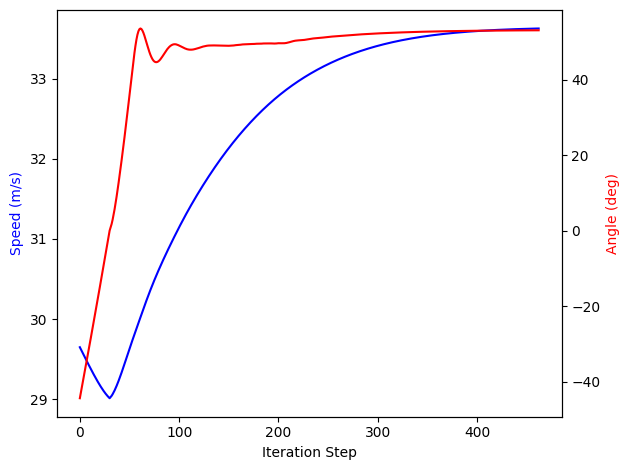

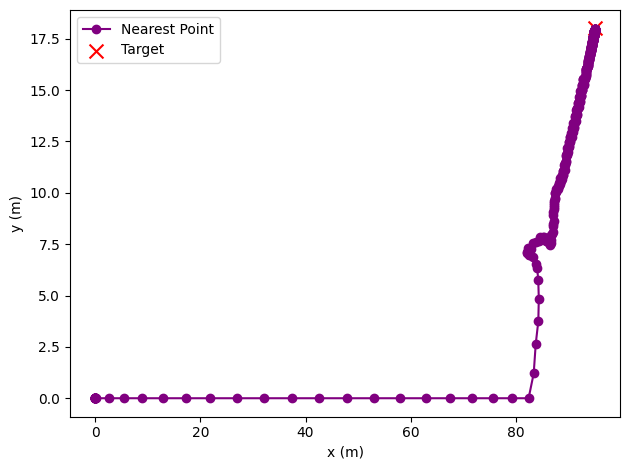

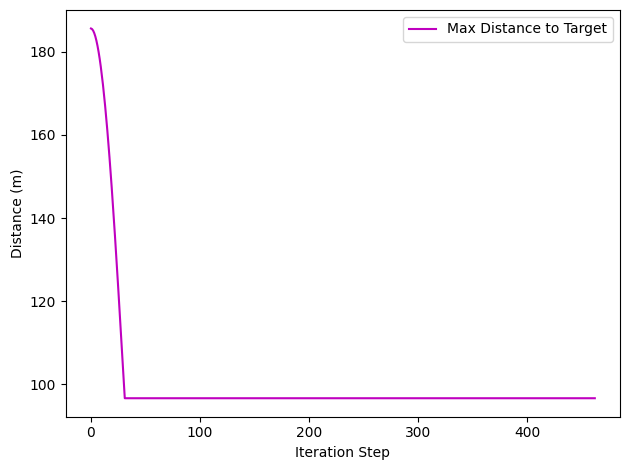

In [96]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from typing import Tuple, Optional

class ProjectileTargetOptimiserMulti:
    def __init__(self, target_x: float, target_y: float, gravity: float = 9.81,
                 w_target: float = 1.0, w_time: float = 0.05):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.target_x = target_x
        self.target_y = target_y
        print(f"Target: ({self.target_x}, {self.target_y}) | Using device: {self.device}")
        self.g = gravity
        self.w_target = w_target
        self.w_time = w_time

        # Initial guesses
        self.velocity = torch.tensor(torch.rand(1).item()*50, requires_grad=True)
        self.angle = torch.tensor(torch.rand(1).item()*np.pi - (np.pi/2) + 0.01, requires_grad=True)

        # History tracking
        self.history_steps = []
        self.history_v = []
        self.history_angle = []
        self.history_apex = []
        self.history_nearest_point = []
        self.history_min_dist = []
        self.history_max_dist = []

    def trajectory(self, n_points: int = 501) -> Tuple[np.ndarray, np.ndarray, Tuple[float,float]]:
        """Return full trajectory and apex"""
        v, θ, g = self.velocity.item(), self.angle.item(), self.g
        t_flight = 2*v*np.sin(θ)/g
        t = np.linspace(0, t_flight, n_points)
        x = v*np.cos(θ)*t
        y = v*np.sin(θ)*t - 0.5*g*t**2
        t_apex = v*np.sin(θ)/g
        x_apex = v*np.cos(θ)*t_apex
        y_apex = v*np.sin(θ)*t_apex - 0.5*g*t_apex**2
        return x, y, (x_apex, y_apex)

    def nearest_point_to_target(self, x: np.ndarray, y: np.ndarray) -> Tuple[float,float]:
        """Return point on trajectory nearest to target"""
        d2 = (x - self.target_x)**2 + (y - self.target_y)**2
        idx = np.argmin(d2)
        return x[idx], y[idx]

    def max_distance_to_target(self, x: np.ndarray, y: np.ndarray) -> float:
        return float(np.max(np.sqrt((x - self.target_x)**2 + (y - self.target_y)**2)))

    def loss(self) -> torch.Tensor:
        v, θ = self.velocity, self.angle

        # Full trajectory for max distance
        n_points = 501
        t_flight = 2*v*torch.sin(θ)/self.g
        t = torch.linspace(0, t_flight, n_points)
        x = v*torch.cos(θ)*t
        y = v*torch.sin(θ)*t - 0.5*self.g*t**2

        # Distance to target
        d2 = (x - self.target_x)**2 + (y - self.target_y)**2
        min_dist = torch.min(torch.sqrt(d2))
        max_dist = torch.max(torch.sqrt(d2))
        self.current_max_dist = max_dist.item()
        self.current_min_dist = min_dist.item()

        # Target loss = squared distance at closest point
        target_loss = 100*min_dist**2

        # Uniform penalty for angles between 40–50 degrees
        angle_deg = θ*180/np.pi
        penalty = 0.0
        if 44.5 <= angle_deg <= 45.5:
            penalty = 10  # uniform penalty

        # Multi-objective: target + flight time + angle penalty
        total_loss = self.w_target*target_loss - self.w_time*(2*v*torch.sin(θ)/self.g) + penalty
        return total_loss

    def optimise_and_gif(
        self,
        steps: int = 5000,
        lr: float = 0.025,
        gif_name: str = "optimisation_multi_final.gif",
        save_every: int = 25,
        early_stop_tol: float = 1e-9
    ):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        frames = []
        sampled_trajectories = []
        xlim = (0, 1.5*self.target_x)
        ylim = (0, 1.5*self.target_y)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            # Clamp values
            self.velocity.data.clamp_(0.1, 100.0)
            self.angle.data.clamp_(-np.pi/2 + 0.01, np.pi/2 - 0.01)

            v = self.velocity.item()
            θ = self.angle.item()
            v_x = v * np.cos(θ)
            v_y = v * np.sin(θ)
            x, y, apex = self.trajectory()

            nearest_point = self.nearest_point_to_target(x, y)

            # Store history
            self.history_steps.append(step)
            self.history_v.append(v)
            self.history_angle.append(θ*180/np.pi)
            self.history_apex.append(apex)
            self.history_nearest_point.append(nearest_point)
            self.history_min_dist.append(self.current_min_dist)
            self.history_max_dist.append(self.current_max_dist)

            if step % save_every == 0:
                print(f"Step {step}: v={v:.2f}, angle={θ*180/np.pi:.2f} deg, "
                      f"v_x={v_x:.2f}, v_y={v_y:.2f}, min_dist={self.history_min_dist[-1]:.2f}")
                sampled_trajectories.append((x, y, apex))

                # Plot snapshot for GIF
                fig, ax = plt.subplots()
                n_traj = len(sampled_trajectories)
                cmap = plt.get_cmap("Blues")
                for i, (xi, yi, ai) in enumerate(sampled_trajectories[:-1]):
                    alpha = 0.3 + 0.7*(i/(n_traj-1)) if n_traj > 1 else 0.5
                    ax.plot(xi, yi, color=cmap(alpha), linewidth=1)
                    ax.scatter(*ai, color="grey", s=20, alpha=0.5)
                # Latest trajectory
                xi, yi, ai = sampled_trajectories[-1]
                ax.plot(xi, yi, color="black", linewidth=2, label=f"Step {step}")
                ax.scatter(*ai, color="orange", s=40, label="Apex")
                ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")
                info_text = f"v={v:.2f} m/s\nangle={θ*180/np.pi:.2f}°\nv_x={v_x:.2f}\nv_y={v_y:.2f}\nmin_dist={self.history_min_dist[-1]:.2f}"
                ax.text(0.02, 0.95, info_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                ax.set_title(f"Trajectories up to step {step}")
                fig.tight_layout()
                fig.canvas.draw()
                frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                frames.append(frame)
                plt.close(fig)

            if L.item() < early_stop_tol:
                print(f"Converged at step {step}")
                break

        # Animate final trajectory
        x_final, y_final, _ = self.trajectory()
        n_points = len(x_final)
        step_size = max(1, n_points//100)
        for i in range(0, n_points, step_size):
            fig, ax = plt.subplots()
            for (xi, yi, _) in sampled_trajectories:
                ax.plot(xi, yi, color='blue', alpha=0.3, linewidth=1)
            ax.plot(x_final[:i+1], y_final[:i+1], color='green', linewidth=4)
            ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100)
            info_text = f"v={self.velocity.item():.2f} m/s\nangle={self.angle.item()*180/np.pi:.2f}°\n" \
                        f"v_x={self.velocity.item()*np.cos(self.angle.item()):.2f}\n" \
                        f"v_y={self.velocity.item()*np.sin(self.angle.item()):.2f}"
            ax.text(0.02, 0.95, info_text, transform=ax.transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=5)
        print(f"Saved {gif_name}")

        # --- Terminal plots ---
        # 1. Speed & Angle vs iteration
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.history_steps, self.history_v, 'b-', label='Speed (m/s)')
        ax2.plot(self.history_steps, self.history_angle, 'r-', label='Angle (deg)')
        ax1.set_xlabel('Iteration Step')
        ax1.set_ylabel('Speed (m/s)', color='b')
        ax2.set_ylabel('Angle (deg)', color='r')
        fig.tight_layout()
        plt.show()

        # 2. Nearest point to target
        fig, ax = plt.subplots()
        nearest_points_x = [p[0] for p in self.history_nearest_point]
        nearest_points_y = [p[1] for p in self.history_nearest_point]
        ax.plot(nearest_points_x, nearest_points_y, 'o-', color='purple', label='Nearest Point')
        ax.scatter(self.target_x, self.target_y, c='red', marker='x', s=100, label='Target')
        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.legend()
        plt.tight_layout()
        plt.show()

        # 3. Maximum distance vs iteration
        fig, ax = plt.subplots()
        ax.plot(self.history_steps, self.history_max_dist, 'm-', label='Max Distance to Target')
        ax.set_xlabel('Iteration Step')
        ax.set_ylabel('Distance (m)')
        ax.legend()
        plt.tight_layout()
        plt.show()


# --- Example usage ---
if __name__ == "__main__":
    opt = ProjectileTargetOptimiserMulti(
        target_x=np.random.randint(0,100),
        target_y=np.random.randint(0,100)
    )
    opt.optimise_and_gif()


Target: (69, 27) | Device: cuda
Step 0: v=9.75, angle=25.64 deg, min_dist=66.87
Step 25: v=10.38, angle=23.36 deg, min_dist=66.79
Step 50: v=11.02, angle=24.38 deg, min_dist=65.54
Step 75: v=11.68, angle=24.84 deg, min_dist=64.39
Step 100: v=12.35, angle=25.35 deg, min_dist=63.09
Step 125: v=13.05, angle=26.01 deg, min_dist=61.63
Step 150: v=13.75, angle=26.78 deg, min_dist=59.99
Step 175: v=14.47, angle=27.70 deg, min_dist=58.16
Step 200: v=15.21, angle=28.81 deg, min_dist=56.11
Step 225: v=15.96, angle=30.17 deg, min_dist=53.82
Step 250: v=16.72, angle=31.85 deg, min_dist=51.27
Step 275: v=17.49, angle=33.94 deg, min_dist=48.46
Step 300: v=18.28, angle=36.54 deg, min_dist=45.46
Step 325: v=19.07, angle=39.64 deg, min_dist=42.43
Step 350: v=19.87, angle=43.11 deg, min_dist=39.61
Step 375: v=20.68, angle=45.19 deg, min_dist=37.15
Step 400: v=21.46, angle=46.36 deg, min_dist=34.80
Step 425: v=22.20, angle=47.25 deg, min_dist=32.53
Step 450: v=22.90, angle=47.56 deg, min_dist=30.34
Step 

C:\Users\jones\AppData\Local\Temp\ipykernel_61084\73624103.py:110: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved looping GIF: optimisation_multi_final.gif


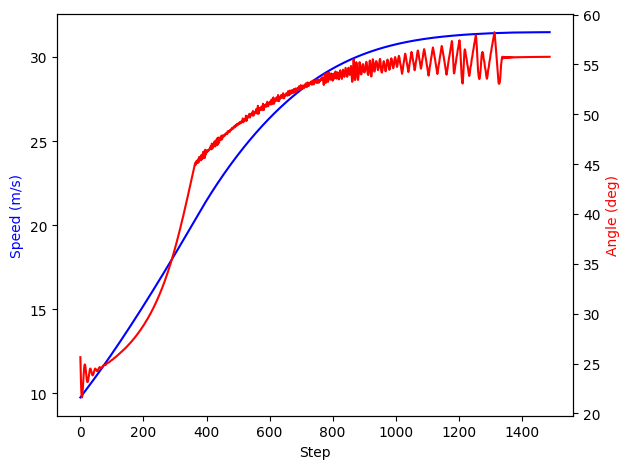

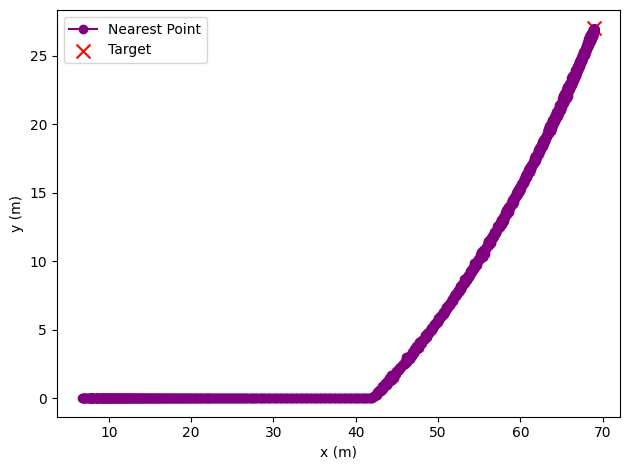

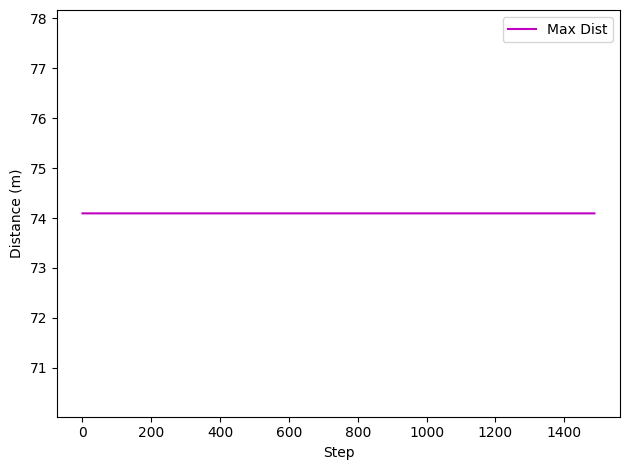

In [100]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from typing import Tuple

class ProjectileTargetOptimiserMulti:
    def __init__(self, target_x: float, target_y: float, gravity: float = 9.81,
                 w_target: float = 1.0, w_time: float = 0.05):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.target_x = target_x
        self.target_y = target_y
        print(f"Target: ({self.target_x}, {self.target_y}) | Device: {self.device}")
        self.g = gravity
        self.w_target = w_target
        self.w_time = w_time

        # Optimisable parameters on device
        self.velocity = torch.tensor(torch.rand(1).item()*50, requires_grad=True, device=self.device)
        self.angle = torch.tensor(torch.rand(1).item()*np.pi - (np.pi/2) + 0.01, requires_grad=True, device=self.device)

        # History tracking
        self.history_steps, self.history_v, self.history_angle = [], [], []
        self.history_nearest_point, self.history_min_dist, self.history_max_dist = [], [], []

    def trajectory_gpu(self, n_points: int = 501) -> Tuple[torch.Tensor, torch.Tensor]:
        v, θ = self.velocity, self.angle
        t_flight = 2*v*torch.sin(θ)/self.g
        t = torch.linspace(0, t_flight, n_points, device=self.device)
        x = v*torch.cos(θ)*t
        y = v*torch.sin(θ)*t - 0.5*self.g*t**2
        return x, y

    def nearest_point_to_target_gpu(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        d2 = (x - self.target_x)**2 + (y - self.target_y)**2
        idx = torch.argmin(d2)
        return x[idx], y[idx]

    def max_distance_to_target_gpu(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return torch.max(torch.sqrt((x - self.target_x)**2 + (y - self.target_y)**2))

    def loss(self) -> torch.Tensor:
        x, y = self.trajectory_gpu()
        d2 = (x - self.target_x)**2 + (y - self.target_y)**2
        min_dist = torch.min(torch.sqrt(d2))
        max_dist = torch.max(torch.sqrt(d2))
        self.current_min_dist = min_dist.item()
        self.current_max_dist = max_dist.item()

        target_loss = 100*min_dist**2

        angle_deg = self.angle*180/np.pi
        penalty = 10.0 if 44.5 <= angle_deg <= 45.5 else 0.0

        total_loss = self.w_target*target_loss - self.w_time*(2*self.velocity*torch.sin(self.angle)/self.g) + penalty
        return total_loss

    def optimise_and_gif(self, steps=5000, lr=0.025, gif_name="optimisation_multi_final.gif",
                         save_every=25, early_stop_tol=1e-9):
        opt = optim.Adam([self.velocity, self.angle], lr=lr)
        sampled_trajectories = []
        xlim, ylim = (0, 1.5*self.target_x), (0, 1.5*self.target_y)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            self.velocity.data.clamp_(0.1, 100.0)
            self.angle.data.clamp_(-np.pi/2 + 0.01, np.pi/2 - 0.01)

            v, θ = self.velocity.item(), self.angle.item()
            x, y = self.trajectory_gpu()
            x_cpu, y_cpu = x.detach().cpu().numpy(), y.detach().cpu().numpy()  # <--- detach here
            nearest_point = self.nearest_point_to_target_gpu(x, y)
            nearest_point_cpu = (nearest_point[0].item(), nearest_point[1].item())


            # Store history
            self.history_steps.append(step)
            self.history_v.append(v)
            self.history_angle.append(θ*180/np.pi)
            self.history_nearest_point.append(nearest_point_cpu)
            self.history_min_dist.append(self.current_min_dist)
            self.history_max_dist.append(self.current_max_dist)

            if step % save_every == 0:
                print(f"Step {step}: v={v:.2f}, angle={θ*180/np.pi:.2f} deg, min_dist={self.history_min_dist[-1]:.2f}")
                sampled_trajectories.append((x_cpu, y_cpu, nearest_point_cpu))

            if L.item() < early_stop_tol:
                print(f"Converged at step {step}")
                break

        # --- Fast GIF generation ---
        frames = []
        for xi, yi, ai in sampled_trajectories:
            fig, ax = plt.subplots()
            ax.plot(xi, yi, color='black', linewidth=2)
            ax.scatter(*ai, color="orange", s=40, label="Nearest Point")
            ax.scatter(self.target_x, self.target_y, c="red", marker="x", s=100, label="Target")
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_xlabel("x (m)")
            ax.set_ylabel("y (m)")
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=10, loop=0)
        print(f"Saved looping GIF: {gif_name}")

        # --- Terminal plots ---
        # Speed & Angle
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.history_steps, self.history_v, 'b-', label='Speed')
        ax2.plot(self.history_steps, self.history_angle, 'r-', label='Angle')
        ax1.set_xlabel("Step"); ax1.set_ylabel("Speed (m/s)", color='b')
        ax2.set_ylabel("Angle (deg)", color='r')
        plt.tight_layout(); plt.show()

        # Nearest point trajectory
        fig, ax = plt.subplots()
        nx = [p[0] for p in self.history_nearest_point]
        ny = [p[1] for p in self.history_nearest_point]
        ax.plot(nx, ny, 'o-', color='purple', label='Nearest Point')
        ax.scatter(self.target_x, self.target_y, c='red', marker='x', s=100, label='Target')
        ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")
        ax.legend(); plt.tight_layout(); plt.show()

        # Max distance
        fig, ax = plt.subplots()
        ax.plot(self.history_steps, self.history_max_dist, 'm-', label='Max Dist')
        ax.set_xlabel("Step"); ax.set_ylabel("Distance (m)"); ax.legend()
        plt.tight_layout(); plt.show()


if __name__ == "__main__":
    opt = ProjectileTargetOptimiserMulti(
        target_x=np.random.randint(0,100),
        target_y=np.random.randint(0,100)
    )
    opt.optimise_and_gif()

In [105]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from typing import Tuple

from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

class ProjectileTargetOptimiser3D:
    def __init__(self, target_x: float, target_y: float, target_z: float, gravity: float = 9.81,
                 w_target: float = 1.0, w_time: float = 0.05):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.target_x, self.target_y, self.target_z = target_x, target_y, target_z
        print(f"Target: ({target_x}, {target_y}, {target_z}) | Device: {self.device}")
        self.g = gravity
        self.w_target = w_target
        self.w_time = w_time

        # Optimisable parameters
        self.velocity = torch.tensor(torch.rand(1).item()*50, requires_grad=True, device=self.device)
        self.theta = torch.tensor(torch.rand(1).item()*(np.pi/2-0.01)+0.01, requires_grad=True, device=self.device)  # elevation
        self.phi = torch.tensor(torch.rand(1).item()*2*np.pi, requires_grad=True, device=self.device)  # azimuth

        # History
        self.history_steps, self.history_v, self.history_theta, self.history_phi = [], [], [], []
        self.history_nearest_point, self.history_min_dist, self.history_max_dist = [], [], []

    def trajectory_gpu(self, n_points: int = 501) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        v, θ, φ = self.velocity, self.theta, self.phi
        t_flight = 2*v*torch.sin(θ)/self.g
        t = torch.linspace(0, t_flight, n_points, device=self.device)
        x = v*torch.cos(θ)*torch.cos(φ)*t
        y = v*torch.sin(θ)*t - 0.5*self.g*t**2
        z = v*torch.cos(θ)*torch.sin(φ)*t
        return x, y, z

    def nearest_point_to_target_gpu(self, x: torch.Tensor, y: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        d2 = (x - self.target_x)**2 + (y - self.target_y)**2 + (z - self.target_z)**2
        idx = torch.argmin(d2)
        return x[idx], y[idx], z[idx]

    def max_distance_to_target_gpu(self, x: torch.Tensor, y: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        return torch.max(torch.sqrt((x - self.target_x)**2 + (y - self.target_y)**2 + (z - self.target_z)**2))

    def loss(self) -> torch.Tensor:
        x, y, z = self.trajectory_gpu()
        d2 = (x - self.target_x)**2 + (y - self.target_y)**2 + (z - self.target_z)**2
        min_dist = torch.min(torch.sqrt(d2))
        max_dist = torch.max(torch.sqrt(d2))
        self.current_min_dist = min_dist.item()
        self.current_max_dist = max_dist.item()

        target_loss = 100*min_dist**2
        angle_deg = self.theta*180/np.pi
        penalty = 10.0 if 44.5 <= angle_deg <= 45.5 else 0.0

        total_loss = self.w_target*target_loss - self.w_time*(2*self.velocity*torch.sin(self.theta)/self.g) + penalty
        return total_loss

    def optimise_and_gif(self, steps=5000, lr=0.025, gif_name="optimisation_3d.gif", save_every=25,
                         early_stop_tol=1e-9):
        opt = optim.Adam([self.velocity, self.theta, self.phi], lr=lr)
        sampled_trajectories = []
        xlim, ylim, zlim = (0, 1.5*self.target_x), (0, 1.5*self.target_y), (1.5*self.target_z, -1.5*self.target_z)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            self.velocity.data.clamp_(0.1, 1000.0)
            self.theta.data.clamp_(-np.pi + 0.01, np.pi - 0.01)
            self.phi.data.clamp_(0, 2*np.pi)

            v, θ, φ = self.velocity.item(), self.theta.item(), self.phi.item()
            x, y, z = self.trajectory_gpu()
            x_cpu, y_cpu, z_cpu = x.detach().cpu().numpy(), y.detach().cpu().numpy(), z.detach().cpu().numpy()
            nearest_point = self.nearest_point_to_target_gpu(x, y, z)
            nearest_point_cpu = tuple(p.item() for p in nearest_point)

            self.history_steps.append(step)
            self.history_v.append(v)
            self.history_theta.append(θ*180/np.pi)
            self.history_phi.append(φ*180/np.pi)
            self.history_nearest_point.append(nearest_point_cpu)
            self.history_min_dist.append(self.current_min_dist)
            self.history_max_dist.append(self.current_max_dist)

            if step % save_every == 0:
                print(f"Step {step}: v={v:.2f}, θ={θ*180/np.pi:.2f}°, φ={φ*180/np.pi:.2f}°, min_dist={self.current_min_dist:.2f}")
                sampled_trajectories.append((x_cpu, y_cpu, z_cpu, nearest_point_cpu))

            if L.item() < early_stop_tol:
                print(f"Converged at step {step}")
                break

        # --- 3D GIF ---
        frames = []
        for xi, yi, zi, ai in sampled_trajectories:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(xi, yi, zi, color='black', linewidth=2)
            ax.scatter(*ai, color='orange', s=40, label="Nearest Point")
            ax.scatter(self.target_x, self.target_y, self.target_z, c='red', marker='x', s=100, label="Target")
            ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
            ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)"); ax.set_zlabel("z (m)")
            fig.tight_layout(); fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=10, loop=0)
        print(f"Saved looping 3D GIF: {gif_name}")

if __name__ == "__main__":
    opt = ProjectileTargetOptimiser3D(
        target_x=np.random.randint(0, 100),
        target_y=np.random.randint(0, 100),
        target_z=np.random.randint(0, 100)
    )
    opt.optimise_and_gif()

Target: (11, 49, 28) | Device: cuda
Step 0: v=6.13, θ=88.41°, φ=279.95°, min_dist=55.98
Step 25: v=6.78, θ=119.63°, φ=253.41°, min_dist=54.80
Step 50: v=7.46, θ=119.91°, φ=248.88°, min_dist=54.23
Step 75: v=8.16, θ=119.73°, φ=247.84°, min_dist=53.59
Step 100: v=8.86, θ=118.94°, φ=248.50°, min_dist=52.89
Step 125: v=9.58, θ=118.64°, φ=248.55°, min_dist=52.12
Step 150: v=10.32, θ=118.26°, φ=248.54°, min_dist=51.28
Step 175: v=11.06, θ=117.86°, φ=248.55°, min_dist=50.37
Step 200: v=11.81, θ=117.42°, φ=248.55°, min_dist=49.39
Step 225: v=12.56, θ=116.99°, φ=248.55°, min_dist=48.34
Step 250: v=13.32, θ=116.52°, φ=248.55°, min_dist=47.22
Step 275: v=14.08, θ=116.08°, φ=248.55°, min_dist=46.04
Step 300: v=14.84, θ=115.59°, φ=248.55°, min_dist=44.80
Step 325: v=15.59, θ=115.16°, φ=248.55°, min_dist=43.50
Step 350: v=16.35, θ=114.69°, φ=248.55°, min_dist=42.15
Step 375: v=17.09, θ=114.16°, φ=248.55°, min_dist=40.76
Step 400: v=17.83, θ=113.76°, φ=248.55°, min_dist=39.32
Step 425: v=18.56, θ=113

C:\Users\jones\AppData\Local\Temp\ipykernel_61084\354662476.py:110: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved looping 3D GIF: optimisation_3d.gif


Target: (-23, 23, -22) | Device: cuda
Step 0: v=26.92, θ=38.22°, φ=320.85°, min_dist=38.24
Step 25: v=27.51, θ=70.73°, φ=283.59°, min_dist=28.21
Step 50: v=26.98, θ=51.08°, φ=245.83°, min_dist=12.81
Step 75: v=27.12, θ=53.03°, φ=221.13°, min_dist=1.37
Step 100: v=27.06, θ=51.97°, φ=222.62°, min_dist=0.73
Converged at step 109


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\243408258.py:120: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved looping 3D GIF: optimisation_3d.gif


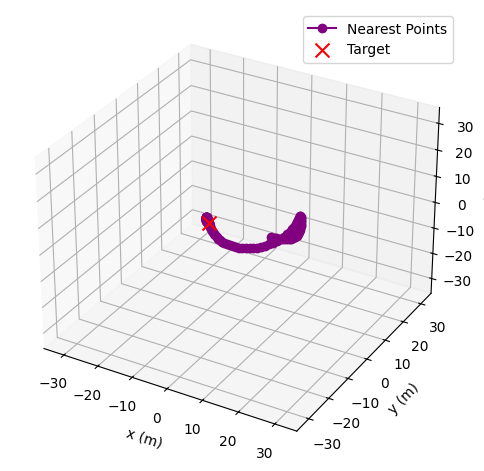

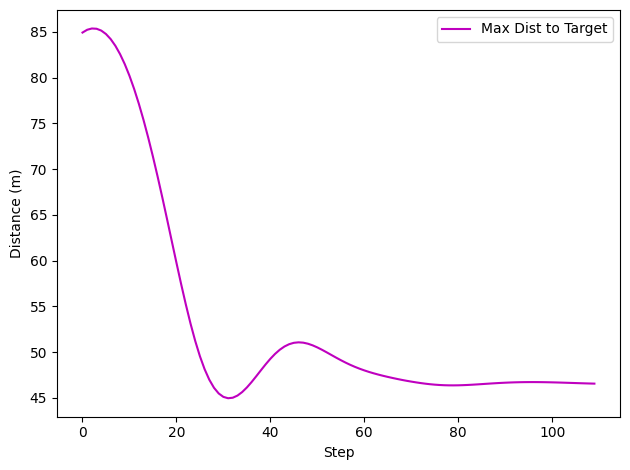

In [111]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from typing import Tuple
from mpl_toolkits.mplot3d import Axes3D

class ProjectileTargetOptimiser3D:
    def __init__(self, target_x: float, target_y: float, target_z: float, gravity: float = 9.81,
                 w_target: float = 1.0, w_time: float = 0.05):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.target_x, self.target_y, self.target_z = target_x, target_y, target_z
        print(f"Target: ({target_x}, {target_y}, {target_z}) | Device: {self.device}")
        self.g = gravity
        self.w_target = w_target
        self.w_time = w_time

        # Optimisable parameters
        self.velocity = torch.tensor(torch.rand(1).item()*50, requires_grad=True, device=self.device)
        self.theta = torch.tensor(torch.rand(1).item()*(np.pi/2-0.01)+0.01, requires_grad=True, device=self.device)
        self.phi = torch.tensor(torch.rand(1).item()*2*np.pi, requires_grad=True, device=self.device)

        # History
        self.history_steps, self.history_v, self.history_theta, self.history_phi = [], [], [], []
        self.history_nearest_point, self.history_min_dist, self.history_max_dist = [], [], []

    def trajectory_gpu(self, n_points: int = 501) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        v, θ, φ = self.velocity, self.theta, self.phi
        t_flight = 2*v*torch.sin(θ)/self.g
        t = torch.linspace(0, t_flight, n_points, device=self.device)
        x = v*torch.cos(θ)*torch.cos(φ)*t
        y = v*torch.sin(θ)*t - 0.5*self.g*t**2
        z = v*torch.cos(θ)*torch.sin(φ)*t
        return x, y, z

    def nearest_point_to_target_gpu(self, x: torch.Tensor, y: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        d2 = (x - self.target_x)**2 + (y - self.target_y)**2 + (z - self.target_z)**2
        idx = torch.argmin(d2)
        return x[idx], y[idx], z[idx]

    def max_distance_to_target_gpu(self, x: torch.Tensor, y: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        return torch.max(torch.sqrt((x - self.target_x)**2 + (y - self.target_y)**2 + (z - self.target_z)**2))

    def loss(self) -> torch.Tensor:
        x, y, z = self.trajectory_gpu()
        d2 = (x - self.target_x)**2 + (y - self.target_y)**2 + (z - self.target_z)**2
        min_dist = torch.min(torch.sqrt(d2))
        max_dist = torch.max(torch.sqrt(d2))
        self.current_min_dist = min_dist.item()
        self.current_max_dist = max_dist.item()

        target_loss = 100*min_dist**2
        angle_deg = self.theta*180/np.pi
        penalty = 10.0 if 44.5 <= angle_deg <= 45.5 else 0.0

        total_loss = self.w_target*target_loss - self.w_time*(2*self.velocity*torch.sin(self.theta)/self.g) + penalty
        return total_loss

    def optimise_and_gif(self, steps=5000, lr=0.025, gif_name="optimisation_3d.gif", save_every=25,
                         early_stop_tol=1e-9):
        opt = optim.Adam([self.velocity, self.theta, self.phi], lr=lr)
        sampled_trajectories = []

        # Determine central limits based on largest absolute target coordinate
        limit = max(abs(self.target_x), abs(self.target_y), abs(self.target_z)) * 1.5
        xlim = (-limit, limit)
        ylim = (-limit, limit)
        zlim = (-limit, limit)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            # Looser clamps to allow negative trajectories
            self.velocity.data.clamp_(-100.0, 100.0)
            self.theta.data.clamp_(-np.pi/2 + 0.01, np.pi/2 - 0.01)
            self.phi.data.clamp_(-2*np.pi, 2*np.pi)

            v, θ, φ = self.velocity.item(), self.theta.item(), self.phi.item()
            x, y, z = self.trajectory_gpu()
            x_cpu, y_cpu, z_cpu = x.detach().cpu().numpy(), y.detach().cpu().numpy(), z.detach().cpu().numpy()
            nearest_point = self.nearest_point_to_target_gpu(x, y, z)
            nearest_point_cpu = tuple(p.item() for p in nearest_point)

            # Store history
            self.history_steps.append(step)
            self.history_v.append(v)
            self.history_theta.append(θ*180/np.pi)
            self.history_phi.append(φ*180/np.pi)
            self.history_nearest_point.append(nearest_point_cpu)
            self.history_min_dist.append(self.current_min_dist)
            self.history_max_dist.append(self.current_max_dist)

            if step % save_every == 0:
                print(f"Step {step}: v={v:.2f}, θ={θ*180/np.pi:.2f}°, φ={φ*180/np.pi:.2f}°, min_dist={self.current_min_dist:.2f}")
                sampled_trajectories.append((x_cpu, y_cpu, z_cpu, nearest_point_cpu, v, θ, φ, self.current_min_dist))

            if L.item() < early_stop_tol:
                print(f"Converged at step {step}")
                break

        # --- Optimisation 3D GIF ---
        frames = []
        for xi, yi, zi, ai, v, θ, φ, min_dist in sampled_trajectories:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(xi, yi, zi, color='black', linewidth=2)
            ax.scatter(*ai, color="orange", s=40, label="Nearest Point")
            ax.scatter(self.target_x, self.target_y, self.target_z, c='red', marker="x", s=100, label="Target")
            info_text = f"v={v:.2f} m/s\nθ={θ*180/np.pi:.2f}°\nφ={φ*180/np.pi:.2f}°\nmin_dist={min_dist:.2f}"
            ax.text2D(0.02, 0.95, info_text, transform=ax.transAxes,
                      fontsize=10, verticalalignment='top',
                      bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
            ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
            ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)"); ax.set_zlabel("z (m)")
            fig.tight_layout(); fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=10, loop=0)
        print(f"Saved looping 3D GIF: {gif_name}")

        # --- 3D Terminal plot for nearest points evolution ---
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        nx = [p[0] for p in self.history_nearest_point]
        ny = [p[1] for p in self.history_nearest_point]
        nz = [p[2] for p in self.history_nearest_point]
        ax.plot(nx, ny, nz, 'o-', color='purple', label='Nearest Points')
        ax.scatter(self.target_x, self.target_y, self.target_z, c='red', marker='x', s=100, label='Target')
        ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
        ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)"); ax.set_zlabel("z (m)")
        ax.legend(); plt.tight_layout(); plt.show()

        # --- Max distance vs iteration ---
        fig, ax = plt.subplots()
        ax.plot(self.history_steps, self.history_max_dist, 'm-', label='Max Dist to Target')
        ax.set_xlabel("Step"); ax.set_ylabel("Distance (m)"); ax.legend()
        plt.tight_layout(); plt.show()


if __name__ == "__main__":
    opt = ProjectileTargetOptimiser3D(
        target_x=np.random.randint(-50,50),
        target_y=np.random.randint(-50,50),
        target_z=np.random.randint(-50,50)
    )
    opt.optimise_and_gif()


Target: (23, 16, 47) | Device: cuda
Step 0: v=9.63, θ=50.73°, φ=161.81°, min_dist=54.46
Step 20: v=10.64, θ=49.28°, φ=104.03°, min_dist=45.51
Step 40: v=11.85, θ=8.69°, φ=53.52°, min_dist=27.08
Step 60: v=12.83, θ=17.21°, φ=67.48°, min_dist=17.24
Step 80: v=13.52, θ=17.98°, φ=63.99°, min_dist=11.59
Step 100: v=14.02, θ=17.36°, φ=63.49°, min_dist=7.89
Step 120: v=14.37, θ=17.13°, φ=63.78°, min_dist=5.32
Step 140: v=14.62, θ=17.05°, φ=63.89°, min_dist=3.52
Step 160: v=14.80, θ=17.01°, φ=63.91°, min_dist=2.27
Step 180: v=14.92, θ=17.00°, φ=63.92°, min_dist=1.43
Step 200: v=15.00, θ=17.00°, φ=63.92°, min_dist=0.87
Step 220: v=15.05, θ=17.00°, φ=63.92°, min_dist=0.51
Step 240: v=15.09, θ=17.00°, φ=63.92°, min_dist=0.29
Step 260: v=15.11, θ=17.00°, φ=63.92°, min_dist=0.16
Converged at step 279


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\3324509680.py:153: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved looping 3D GIF: optimisation_3d_origin_force.gif


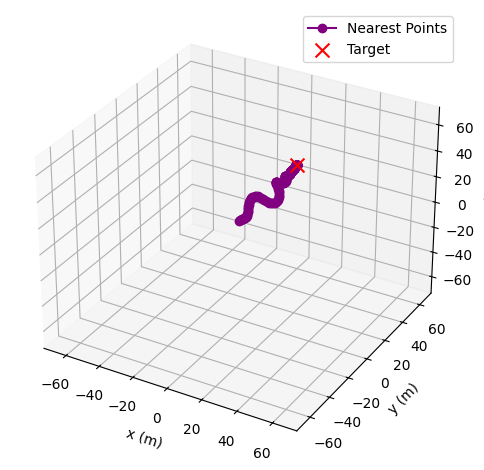

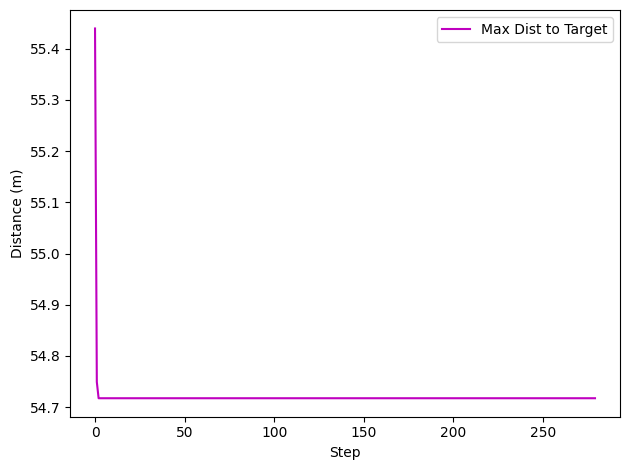

In [113]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from typing import Tuple
from mpl_toolkits.mplot3d import Axes3D

class ProjectileTargetOptimiser3DOriginForce:
    def __init__(self, target_x: float, target_y: float, target_z: float,
                 force_strength: float = 9.81, force_exponent: float = 2.0,
                 w_target: float = 1.0, w_time: float = 0.05):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.target_x, self.target_y, self.target_z = target_x, target_y, target_z
        print(f"Target: ({target_x}, {target_y}, {target_z}) | Device: {self.device}")

        self.force_strength = force_strength
        self.force_exponent = force_exponent
        self.w_target = w_target
        self.w_time = w_time

        # Optimisable parameters
        self.velocity = torch.tensor(torch.rand(1).item()*50, requires_grad=True, device=self.device)
        self.theta = torch.tensor(torch.rand(1).item()*(np.pi/2-0.01)+0.01, requires_grad=True, device=self.device)
        self.phi = torch.tensor(torch.rand(1).item()*2*np.pi, requires_grad=True, device=self.device)

        # History
        self.history_steps, self.history_v, self.history_theta, self.history_phi = [], [], [], []
        self.history_nearest_point, self.history_min_dist, self.history_max_dist = [], [], []

    def trajectory_gpu(self, n_points: int = 501, dt: float = 0.01) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Compute trajectory with origin-seeking force; functional to avoid in-place ops"""
        v, θ, φ = self.velocity, self.theta, self.phi
        vx = v*torch.cos(θ)*torch.cos(φ)
        vy = v*torch.sin(θ)
        vz = v*torch.cos(θ)*torch.sin(φ)

        x_list = [torch.tensor(0., device=self.device)]
        y_list = [torch.tensor(0., device=self.device)]
        z_list = [torch.tensor(0., device=self.device)]
        vx_list = [vx]
        vy_list = [vy]
        vz_list = [vz]

        for _ in range(1, n_points):
            r = torch.sqrt(x_list[-1]**2 + y_list[-1]**2 + z_list[-1]**2) + 1e-6
            ax = -self.force_strength * x_list[-1] / r**self.force_exponent
            ay = -self.force_strength * y_list[-1] / r**self.force_exponent
            az = -self.force_strength * z_list[-1] / r**self.force_exponent

            vx_new = vx_list[-1] + ax*dt
            vy_new = vy_list[-1] + ay*dt
            vz_new = vz_list[-1] + az*dt

            x_new = x_list[-1] + vx_new*dt
            y_new = y_list[-1] + vy_new*dt
            z_new = z_list[-1] + vz_new*dt

            vx_list.append(vx_new)
            vy_list.append(vy_new)
            vz_list.append(vz_new)
            x_list.append(x_new)
            y_list.append(y_new)
            z_list.append(z_new)

        x = torch.stack(x_list)
        y = torch.stack(y_list)
        z = torch.stack(z_list)
        return x, y, z

    def nearest_point_to_target_gpu(self, x: torch.Tensor, y: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        d2 = (x - self.target_x)**2 + (y - self.target_y)**2 + (z - self.target_z)**2
        idx = torch.argmin(d2)
        return x[idx], y[idx], z[idx]

    def max_distance_to_target_gpu(self, x: torch.Tensor, y: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        return torch.max(torch.sqrt((x - self.target_x)**2 + (y - self.target_y)**2 + (z - self.target_z)**2))

    def loss(self) -> torch.Tensor:
        x, y, z = self.trajectory_gpu()
        d2 = (x - self.target_x)**2 + (y - self.target_y)**2 + (z - self.target_z)**2
        min_dist = torch.min(torch.sqrt(d2))
        max_dist = torch.max(torch.sqrt(d2))
        self.current_min_dist = min_dist.item()
        self.current_max_dist = max_dist.item()

        target_loss = 100*min_dist**2
        angle_deg = self.theta*180/np.pi
        penalty = 10.0 if 44.5 <= angle_deg <= 45.5 else 0.0

        total_loss = self.w_target*target_loss - self.w_time*(self.velocity) + penalty
        return total_loss

    def optimise_and_gif(self, steps=3000, lr=0.05, gif_name="optimisation_3d_origin_force.gif",
                         save_every=20, early_stop_tol=1e-6):
        opt = optim.Adam([self.velocity, self.theta, self.phi], lr=lr)
        sampled_trajectories = []

        limit = max(abs(self.target_x), abs(self.target_y), abs(self.target_z)) * 1.5
        xlim = (-limit, limit)
        ylim = (-limit, limit)
        zlim = (-limit, limit)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            # Looser clamps
            self.velocity.data.clamp_(-100.0, 100.0)
            self.theta.data.clamp_(-np.pi/2 + 0.01, np.pi/2 - 0.01)
            self.phi.data.clamp_(-2*np.pi, 2*np.pi)

            v, θ, φ = self.velocity.item(), self.theta.item(), self.phi.item()
            x, y, z = self.trajectory_gpu()
            x_cpu, y_cpu, z_cpu = x.detach().cpu().numpy(), y.detach().cpu().numpy(), z.detach().cpu().numpy()
            nearest_point = self.nearest_point_to_target_gpu(x, y, z)
            nearest_point_cpu = tuple(p.item() for p in nearest_point)

            # Store history
            self.history_steps.append(step)
            self.history_v.append(v)
            self.history_theta.append(θ*180/np.pi)
            self.history_phi.append(φ*180/np.pi)
            self.history_nearest_point.append(nearest_point_cpu)
            self.history_min_dist.append(self.current_min_dist)
            self.history_max_dist.append(self.current_max_dist)

            if step % save_every == 0:
                print(f"Step {step}: v={v:.2f}, θ={θ*180/np.pi:.2f}°, φ={φ*180/np.pi:.2f}°, min_dist={self.current_min_dist:.2f}")
                sampled_trajectories.append((x_cpu, y_cpu, z_cpu, nearest_point_cpu, v, θ, φ, self.current_min_dist))

            if L.item() < early_stop_tol:
                print(f"Converged at step {step}")
                break

        # --- Optimisation GIF ---
        frames = []
        for xi, yi, zi, ai, v, θ, φ, min_dist in sampled_trajectories:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(xi, yi, zi, color='black', linewidth=2)
            ax.scatter(*ai, color="orange", s=40, label="Nearest Point")
            ax.scatter(self.target_x, self.target_y, self.target_z, c='red', marker="x", s=100, label="Target")
            info_text = f"v={v:.2f} m/s\nθ={θ*180/np.pi:.2f}°\nφ={φ*180/np.pi:.2f}°\nmin_dist={min_dist:.2f}"
            ax.text2D(0.02, 0.95, info_text, transform=ax.transAxes,
                      fontsize=10, verticalalignment='top',
                      bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
            ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
            ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)"); ax.set_zlabel("z (m)")
            fig.tight_layout(); fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=10, loop=0)
        print(f"Saved looping 3D GIF: {gif_name}")

        # --- Terminal plot for nearest points evolution ---
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        nx = [p[0] for p in self.history_nearest_point]
        ny = [p[1] for p in self.history_nearest_point]
        nz = [p[2] for p in self.history_nearest_point]
        ax.plot(nx, ny, nz, 'o-', color='purple', label='Nearest Points')
        ax.scatter(self.target_x, self.target_y, self.target_z, c='red', marker='x', s=100, label='Target')
        ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
        ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)"); ax.set_zlabel("z (m)")
        ax.legend(); plt.tight_layout(); plt.show()

        # --- Max distance vs iteration ---
        fig, ax = plt.subplots()
        ax.plot(self.history_steps, self.history_max_dist, 'm-', label='Max Dist to Target')
        ax.set_xlabel("Step"); ax.set_ylabel("Distance (m)"); ax.legend()
        plt.tight_layout(); plt.show()


if __name__ == "__main__":
    opt = ProjectileTargetOptimiser3DOriginForce(
        target_x=np.random.randint(-50,50),
        target_y=np.random.randint(-50,50),
        target_z=np.random.randint(-50,50),
        force_strength=9.81,
        force_exponent=2.0
    )
    opt.optimise_and_gif()


In [117]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple

class ProjectileTargetOptimiser3DMultiAttractVectors:
    def __init__(self, target_x: float, target_y: float, target_z: float,
                 w_target: float = 1.0, w_time: float = 0.05,
                 n_forces_range: Tuple[int,int]=(1,5), G_range: Tuple[float,float]=(1,20),
                 grid_range: Tuple[int,int]=(-50,50)):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.target = torch.tensor([target_x, target_y, target_z], dtype=torch.float32, device=self.device)
        print(f"Target: {self.target.cpu().numpy()} | Device: {self.device}")

        self.w_target = w_target
        self.w_time = w_time

        # Random attractive points
        self.n_forces = np.random.randint(n_forces_range[0], n_forces_range[1]+1)
        self.attract_points = torch.tensor(
            np.random.uniform(grid_range[0], grid_range[1], size=(self.n_forces,3)),
            dtype=torch.float32, device=self.device
        )
        self.Gs = torch.tensor(
            np.random.uniform(G_range[0], G_range[1], size=(self.n_forces,)),
            dtype=torch.float32, device=self.device
        )
        print(f"{self.n_forces} attractors, strengths: {self.Gs.cpu().numpy()}")
        print(f"Positions:\n{self.attract_points.cpu().numpy()}")

        # Optimisable parameters
        self.velocity = torch.tensor(torch.rand(1).item()*50, requires_grad=True, device=self.device)
        self.theta = torch.tensor(torch.rand(1).item()*(np.pi/2-0.01)+0.01, requires_grad=True, device=self.device)
        self.phi = torch.tensor(torch.rand(1).item()*2*np.pi, requires_grad=True, device=self.device)

        # History
        self.history_steps, self.history_v, self.history_theta, self.history_phi = [], [], [], []
        self.history_nearest_point, self.history_min_dist, self.history_max_dist = [], [], []

    # --- Vectorised RK4 integration ---
    def trajectory_rk4_gpu(self, dt=0.01, n_steps=1000):
        pos = torch.zeros(3, device=self.device)
        v0 = self.velocity
        θ, φ = self.theta, self.phi
        vel = torch.tensor([v0*torch.cos(θ)*torch.cos(φ),
                            v0*torch.sin(θ),
                            v0*torch.cos(θ)*torch.sin(φ)], device=self.device)

        traj = torch.zeros((n_steps,3), device=self.device)

        for i in range(n_steps):
            traj[i] = pos

            def acceleration(p, vel):
                r_vecs = self.attract_points - p.unsqueeze(0)  # (n_forces,3)
                r_mag = torch.norm(r_vecs, dim=1, keepdim=True)
                return torch.sum(self.Gs.unsqueeze(1) * r_vecs / (r_mag**3 + 1e-6), dim=0)

            k1_v = acceleration(pos, vel) * dt
            k1_x = vel * dt

            k2_v = acceleration(pos + 0.5*k1_x, vel + 0.5*k1_v) * dt
            k2_x = (vel + 0.5*k1_v) * dt

            k3_v = acceleration(pos + 0.5*k2_x, vel + 0.5*k2_v) * dt
            k3_x = (vel + 0.5*k2_v) * dt

            k4_v = acceleration(pos + k3_x, vel + k3_v) * dt
            k4_x = (vel + k3_v) * dt

            pos = pos + (k1_x + 2*k2_x + 2*k3_x + k4_x)/6
            vel = vel + (k1_v + 2*k2_v + 2*k3_v + k4_v)/6

        return traj[:,0], traj[:,1], traj[:,2]

    def nearest_point_to_target_gpu(self, x, y, z):
        d2 = (x - self.target[0])**2 + (y - self.target[1])**2 + (z - self.target[2])**2
        idx = torch.argmin(d2)
        return x[idx], y[idx], z[idx]

    def loss(self):
        x, y, z = self.trajectory_rk4_gpu()
        d2 = (x - self.target[0])**2 + (y - self.target[1])**2 + (z - self.target[2])**2
        min_dist = torch.min(torch.sqrt(d2))
        max_dist = torch.max(torch.sqrt(d2))
        self.current_min_dist = min_dist.item()
        self.current_max_dist = max_dist.item()
        target_loss = 100*min_dist**2
        penalty = 10.0 if 44.5 <= self.theta*180/np.pi <= 45.5 else 0.0
        return self.w_target*target_loss - self.w_time*self.velocity + penalty

    def optimise_and_gif(self, steps=100, lr=0.5, gif_name="optimisation_3d_multi_vector.gif", save_every=5):
        opt = optim.Adam([self.velocity, self.theta, self.phi], lr=lr)
        sampled_trajectories = []

        limit = max(abs(self.target[0]), abs(self.target[1]), abs(self.target[2]))*1.5
        limit = float(max(abs(self.target[0].item()), abs(self.target[1].item()), abs(self.target[2].item())) * 1.5)
        xlim = (-limit, limit)
        ylim = (-limit, limit)
        zlim = (-limit, limit)


        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            # Looser clamps
            self.velocity.data.clamp_(-100,100)
            self.theta.data.clamp_(-np.pi/2+0.01, np.pi/2-0.01)
            self.phi.data.clamp_(-2*np.pi, 2*np.pi)

            v, θ, φ = self.velocity.item(), self.theta.item(), self.phi.item()
            x, y, z = self.trajectory_rk4_gpu()
            x_cpu, y_cpu, z_cpu = x.detach().cpu().numpy(), y.detach().cpu().numpy(), z.detach().cpu().numpy()
            nearest_point = self.nearest_point_to_target_gpu(x, y, z)
            nearest_point_cpu = tuple(p.item() for p in nearest_point)

            self.history_steps.append(step)
            self.history_v.append(v)
            self.history_theta.append(θ*180/np.pi)
            self.history_phi.append(φ*180/np.pi)
            self.history_nearest_point.append(nearest_point_cpu)
            self.history_min_dist.append(self.current_min_dist)
            self.history_max_dist.append(self.current_max_dist)

            if step % save_every == 0:
                print(f"Step {step}: v={v:.2f}, θ={θ*180/np.pi:.2f}°, φ={φ*180/np.pi:.2f}°, min_dist={self.current_min_dist:.2f}")
                sampled_trajectories.append((x_cpu, y_cpu, z_cpu, nearest_point_cpu, v, θ, φ, self.current_min_dist))

        # --- GIF with force vectors ---
        frames = []
        for xi, yi, zi, ai, v, θ, φ, min_dist in sampled_trajectories:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(xi, yi, zi, color='black', linewidth=2)
            ax.scatter(*ai, color='orange', s=40, label='Nearest Point')
            ax.scatter(*self.target.cpu().numpy(), c='red', marker='x', s=100, label='Target')
            # Force vectors
            for pos, G in zip(self.attract_points.cpu().numpy(), self.Gs.cpu().numpy()):
                ax.quiver(pos[0], pos[1], pos[2],
                          -pos[0]*0.1, -pos[1]*0.1, -pos[2]*0.1, color='blue', length=5, normalize=True)
            info_text = f"v={v:.2f} m/s\nθ={θ*180/np.pi:.2f}°\nφ={φ*180/np.pi:.2f}°\nmin_dist={min_dist:.2f}"
            ax.text2D(0.02, 0.95, info_text, transform=ax.transAxes,
                      fontsize=10, verticalalignment='top',
                      bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
            ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
            ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)"); ax.set_zlabel("z (m)")
            fig.tight_layout(); fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=10, loop=0)
        print(f"Saved looping 3D GIF: {gif_name}")

# --- Run ---
if __name__ == "__main__":
    opt = ProjectileTargetOptimiser3DMultiAttractVectors(
        target_x=np.random.randint(-50,50),
        target_y=np.random.randint(-50,50),
        target_z=np.random.randint(-50,50)
    )
    opt.optimise_and_gif()


Target: [-50. -27. -32.] | Device: cuda
5 attractors, strengths: [ 2.8846147  9.890077   7.216586  19.919703  11.610683 ]
Positions:
[[ 21.831451  -33.041405  -23.435585 ]
 [ -6.2244945  21.93881    48.373665 ]
 [-14.555429   11.471826  -36.31222  ]
 [-44.93803    35.330227   26.063812 ]
 [ -7.295952   11.709232  -23.36285  ]]
Step 0: v=10.98, θ=1.18°, φ=268.51°, min_dist=56.39
Step 5: v=13.48, θ=1.18°, φ=268.51°, min_dist=56.40
Step 10: v=15.98, θ=1.18°, φ=268.51°, min_dist=56.40
Step 15: v=18.48, θ=1.18°, φ=268.51°, min_dist=56.40
Step 20: v=20.98, θ=1.18°, φ=268.51°, min_dist=56.40
Step 25: v=23.48, θ=1.18°, φ=268.51°, min_dist=56.40
Step 30: v=25.98, θ=1.18°, φ=268.51°, min_dist=56.41
Step 35: v=28.48, θ=1.18°, φ=268.51°, min_dist=56.41
Step 40: v=30.98, θ=1.18°, φ=268.51°, min_dist=56.41
Step 45: v=33.48, θ=1.18°, φ=268.51°, min_dist=56.41
Step 50: v=35.98, θ=1.18°, φ=268.51°, min_dist=56.41
Step 55: v=38.48, θ=1.18°, φ=268.51°, min_dist=56.41
Step 60: v=40.98, θ=1.18°, φ=268.51°,

C:\Users\jones\AppData\Local\Temp\ipykernel_61084\1039593794.py:155: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved looping 3D GIF: optimisation_3d_multi_vector.gif


In [118]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from typing import Tuple
from mpl_toolkits.mplot3d import Axes3D

class ProjectileTargetOptimiser3DMultiAttractVectors:
    def __init__(self, target_x: float, target_y: float, target_z: float,
                 w_target: float = 1.0, w_time: float = 0.01,
                 n_forces_range: Tuple[int,int]=(1,5), G_range: Tuple[float,float]=(1,20),
                 grid_range: Tuple[int,int]=(-50,50)):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.target = torch.tensor([target_x, target_y, target_z], dtype=torch.float32, device=self.device)
        print(f"Target: {self.target.cpu().numpy()} | Device: {self.device}")

        self.w_target = w_target
        self.w_time = w_time

        # Random attractive points
        self.n_forces = np.random.randint(n_forces_range[0], n_forces_range[1]+1)
        self.attract_points = torch.tensor(
            np.random.uniform(grid_range[0], grid_range[1], size=(self.n_forces,3)),
            dtype=torch.float32, device=self.device
        )
        self.Gs = torch.tensor(
            np.random.uniform(G_range[0], G_range[1], size=(self.n_forces,)),
            dtype=torch.float32, device=self.device
        )
        print(f"{self.n_forces} attractors, strengths: {self.Gs.cpu().numpy()}")
        print(f"Positions:\n{self.attract_points.cpu().numpy()}")

        # Optimisable parameters
        self.velocity = torch.tensor(torch.rand(1).item()*50, requires_grad=True, device=self.device)
        self.theta = torch.tensor(torch.rand(1).item()*(np.pi/2-0.01)+0.01, requires_grad=True, device=self.device)
        self.phi = torch.tensor(torch.rand(1).item()*2*np.pi, requires_grad=True, device=self.device)

        # History
        self.history_steps, self.history_v, self.history_theta, self.history_phi = [], [], [], []
        self.history_nearest_point, self.history_min_dist, self.history_max_dist = [], [], []

    # --- Differentiable RK4 integration ---
    def trajectory_rk4_gpu(self, dt=0.01, n_steps=1000):
        pos = torch.zeros(3, device=self.device)
        v0 = self.velocity
        θ, φ = self.theta, self.phi
        vel = torch.tensor([v0*torch.cos(θ)*torch.cos(φ),
                            v0*torch.sin(θ),
                            v0*torch.cos(θ)*torch.sin(φ)], device=self.device)

        traj = torch.zeros((n_steps,3), device=self.device)

        for i in range(n_steps):
            traj[i] = pos

            def acceleration(p):
                r_vecs = self.attract_points - p.unsqueeze(0)  # (n_forces,3)
                r_mag = torch.norm(r_vecs, dim=1, keepdim=True) + 1e-6
                return torch.sum(self.Gs.unsqueeze(1) * r_vecs / (r_mag**3), dim=0)

            k1_v = acceleration(pos) * dt
            k1_x = vel * dt

            k2_v = acceleration(pos + 0.5*k1_x) * dt
            k2_x = (vel + 0.5*k1_v) * dt

            k3_v = acceleration(pos + 0.5*k2_x) * dt
            k3_x = (vel + 0.5*k2_v) * dt

            k4_v = acceleration(pos + k3_x) * dt
            k4_x = (vel + k3_v) * dt

            pos = pos + (k1_x + 2*k2_x + 2*k3_x + k4_x)/6
            vel = vel + (k1_v + 2*k2_v + 2*k3_v + k4_v)/6

        return traj[:,0], traj[:,1], traj[:,2]

    def nearest_point_to_target_gpu(self, x, y, z):
        d2 = (x - self.target[0])**2 + (y - self.target[1])**2 + (z - self.target[2])**2
        idx = torch.argmin(d2)
        return x[idx], y[idx], z[idx]

    def loss(self):
        x, y, z = self.trajectory_rk4_gpu()
        d2 = (x - self.target[0])**2 + (y - self.target[1])**2 + (z - self.target[2])**2
        min_dist = torch.min(torch.sqrt(d2))
        max_dist = torch.max(torch.sqrt(d2))
        self.current_min_dist = min_dist.item()
        self.current_max_dist = max_dist.item()

        target_loss = self.w_target * min_dist**2
        velocity_penalty = self.w_time * self.velocity**2
        return target_loss + velocity_penalty

    def optimise_and_gif(self, steps=500, lr=0.05, gif_name="optimisation_3d_multi_vector.gif", save_every=20):
        opt = optim.Adam([self.velocity, self.theta, self.phi], lr=lr)
        sampled_trajectories = []

        # Central limits for plotting
        limit = float(max(torch.abs(self.target).cpu().numpy())) * 1.5
        xlim = (-limit, limit)
        ylim = (-limit, limit)
        zlim = (-limit, limit)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            # Looser clamps
            self.velocity.data.clamp_(-100,100)
            self.theta.data.clamp_(-np.pi/2+0.01, np.pi/2-0.01)
            self.phi.data.clamp_(-2*np.pi, 2*np.pi)

            v, θ, φ = self.velocity.item(), self.theta.item(), self.phi.item()
            x, y, z = self.trajectory_rk4_gpu()
            x_cpu, y_cpu, z_cpu = x.detach().cpu().numpy(), y.detach().cpu().numpy(), z.detach().cpu().numpy()
            nearest_point = self.nearest_point_to_target_gpu(x, y, z)
            nearest_point_cpu = tuple(p.item() for p in nearest_point)

            self.history_steps.append(step)
            self.history_v.append(v)
            self.history_theta.append(θ*180/np.pi)
            self.history_phi.append(φ*180/np.pi)
            self.history_nearest_point.append(nearest_point_cpu)
            self.history_min_dist.append(self.current_min_dist)
            self.history_max_dist.append(self.current_max_dist)

            if step % save_every == 0:
                print(f"Step {step}: v={v:.2f}, θ={θ*180/np.pi:.2f}°, φ={φ*180/np.pi:.2f}°, min_dist={self.current_min_dist:.2f}")
                sampled_trajectories.append((x_cpu, y_cpu, z_cpu, nearest_point_cpu, v, θ, φ, self.current_min_dist))

        # --- GIF ---
        frames = []
        for xi, yi, zi, ai, v, θ, φ, min_dist in sampled_trajectories:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(xi, yi, zi, color='black', linewidth=2)
            ax.scatter(*ai, color='orange', s=40, label='Nearest Point')
            ax.scatter(*self.target.cpu().numpy(), c='red', marker='x', s=100, label='Target')

            # Force vectors
            for pos, G in zip(self.attract_points.cpu().numpy(), self.Gs.cpu().numpy()):
                ax.quiver(pos[0], pos[1], pos[2],
                          -pos[0]*0.1, -pos[1]*0.1, -pos[2]*0.1, color='blue', length=5, normalize=True)

            info_text = f"v={v:.2f} m/s\nθ={θ*180/np.pi:.2f}°\nφ={φ*180/np.pi:.2f}°\nmin_dist={min_dist:.2f}"
            ax.text2D(0.02, 0.95, info_text, transform=ax.transAxes,
                      fontsize=10, verticalalignment='top',
                      bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

            ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
            ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)"); ax.set_zlabel("z (m)")
            fig.tight_layout(); fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=10, loop=0)
        print(f"Saved looping 3D GIF: {gif_name}")


# --- Run ---
if __name__ == "__main__":
    opt = ProjectileTargetOptimiser3DMultiAttractVectors(
        target_x=np.random.randint(-50,50),
        target_y=np.random.randint(-50,50),
        target_z=np.random.randint(-50,50)
    )
    opt.optimise_and_gif()


Target: [-12.  23. -43.] | Device: cuda
5 attractors, strengths: [ 6.757886   5.682616  17.491383   6.059414   2.7696319]
Positions:
[[ -6.520416  -38.57852    24.473099 ]
 [-12.564688  -45.96438    11.256044 ]
 [-16.803558  -28.716583    5.7417192]
 [ 10.310173  -36.377026   21.207605 ]
 [-18.078201  -34.976818  -42.077972 ]]
Step 0: v=13.86, θ=47.87°, φ=18.56°, min_dist=50.22
Step 20: v=12.86, θ=47.87°, φ=18.56°, min_dist=50.22
Step 40: v=11.89, θ=47.87°, φ=18.56°, min_dist=50.22
Step 60: v=10.95, θ=47.87°, φ=18.56°, min_dist=50.22
Step 80: v=10.06, θ=47.87°, φ=18.56°, min_dist=50.22
Step 100: v=9.20, θ=47.87°, φ=18.56°, min_dist=50.22
Step 120: v=8.39, θ=47.87°, φ=18.56°, min_dist=50.22
Step 140: v=7.62, θ=47.87°, φ=18.56°, min_dist=50.22
Step 160: v=6.90, θ=47.87°, φ=18.56°, min_dist=50.22
Step 180: v=6.22, θ=47.87°, φ=18.56°, min_dist=50.22
Step 200: v=5.58, θ=47.87°, φ=18.56°, min_dist=50.22
Step 220: v=4.99, θ=47.87°, φ=18.56°, min_dist=50.22
Step 240: v=4.44, θ=47.87°, φ=18.56°

C:\Users\jones\AppData\Local\Temp\ipykernel_61084\4187782451.py:158: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved looping 3D GIF: optimisation_3d_multi_vector.gif


In [130]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple

class ProjectileTargetOptimiser3DMultiAttractVectors:
    def __init__(self, target_x: float, target_y: float, target_z: float,
                 w_target: float = 1.0, w_time: float = 0.01,
                 n_forces_range: Tuple[int,int]=(3,10), G_range: Tuple[float,float]=(250,500),
                 grid_range: Tuple[int,int]=(-100,100)):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.target = torch.tensor([target_x, target_y, target_z], dtype=torch.float32, device=self.device)
        print(f"Target: {self.target.cpu().numpy()} | Device: {self.device}")

        self.w_target = w_target
        self.w_time = w_time

        # Random attractors
        self.n_forces = np.random.randint(n_forces_range[0], n_forces_range[1]+1)
        self.attract_points = torch.tensor(
            np.random.uniform(grid_range[0], grid_range[1], size=(self.n_forces,3)),
            dtype=torch.float32, device=self.device
        )
        self.Gs = torch.tensor(
            np.random.uniform(G_range[0], G_range[1], size=(self.n_forces,)),
            dtype=torch.float32, device=self.device
        )
        print(f"{self.n_forces} attractors, strengths: {self.Gs.cpu().numpy()}")
        print(f"Positions:\n{self.attract_points.cpu().numpy()}")

        # Optimisable parameters
        self.velocity = torch.tensor(0.0 + 5.0*torch.rand(1).item(), requires_grad=True, device=self.device)
        self.theta = torch.tensor(torch.rand(1).item()*(np.pi/2-0.01)+0.01, requires_grad=True, device=self.device)
        self.phi = torch.tensor(torch.rand(1).item()*2*np.pi, requires_grad=True, device=self.device)

        # History
        self.history_steps, self.history_v, self.history_theta, self.history_phi = [], [], [], []
        self.history_nearest_point, self.history_min_dist, self.history_max_dist = [], [], []

    def trajectory_rk4_gpu(self, dt=2, n_steps=1000):
        pos = torch.zeros(3, device=self.device)
        θ, φ = self.theta, self.phi
        v0 = self.velocity
        vel = torch.tensor([v0*torch.cos(θ)*torch.cos(φ),
                            v0*torch.sin(θ),
                            v0*torch.cos(θ)*torch.sin(φ)], device=self.device)

        traj = torch.zeros((n_steps,3), device=self.device)

        for i in range(n_steps):
            traj[i] = pos

            def acceleration(p):
                r_vecs = self.attract_points - p.unsqueeze(0)  # (n_forces,3)
                r_mag = torch.norm(r_vecs, dim=1, keepdim=True)
                return torch.sum(self.Gs.unsqueeze(1) * r_vecs / (r_mag**3 + 1e-6), dim=0)

            k1_v = acceleration(pos) * dt
            k1_x = vel * dt
            k2_v = acceleration(pos + 0.5*k1_x) * dt
            k2_x = (vel + 0.5*k1_v) * dt
            k3_v = acceleration(pos + 0.5*k2_x) * dt
            k3_x = (vel + 0.5*k2_v) * dt
            k4_v = acceleration(pos + k3_x) * dt
            k4_x = (vel + k3_v) * dt

            pos = pos + (k1_x + 2*k2_x + 2*k3_x + k4_x)/6
            vel = vel + (k1_v + 2*k2_v + 2*k3_v + k4_v)/6

        return traj[:,0], traj[:,1], traj[:,2]

    def nearest_point_to_target_gpu(self, x, y, z):
        d2 = (x - self.target[0])**2 + (y - self.target[1])**2 + (z - self.target[2])**2
        idx = torch.argmin(d2)
        return x[idx], y[idx], z[idx]

    def loss(self):
        x, y, z = self.trajectory_rk4_gpu()
        d2 = (x - self.target[0])**2 + (y - self.target[1])**2 + (z - self.target[2])**2
        # smooth soft-min loss
        w = torch.exp(-d2)
        smooth_min = torch.sum(d2 * w) / torch.sum(w)
        
        self.current_min_dist = torch.sqrt(torch.min(d2)).item()
        self.current_max_dist = torch.sqrt(torch.max(d2)).item()
        penalty = 10.0 if 44.5 <= self.theta*180/np.pi <= 45.5 else 0.0
        
        return 1000*self.w_target*smooth_min - self.w_time*self.velocity + penalty

    def optimise_and_gif(self, steps=10, lr_v=5, lr_angles=5, gif_name="optimisation_3d_multi_vector.gif", save_every=2):
        opt = optim.Adam([
            {'params':[self.velocity], 'lr': lr_v},
            {'params':[self.theta, self.phi], 'lr': lr_angles}
        ])
        sampled_trajectories = []

        limit = float(max(abs(self.target[0].item()), abs(self.target[1].item()), abs(self.target[2].item())) * 1.5)
        xlim = (-limit, limit)
        ylim = (-limit, limit)
        zlim = (-limit, limit)

        for step in range(steps):
            opt.zero_grad()
            L = self.loss()
            L.backward()
            opt.step()

            # clamp ranges
            self.velocity.data.clamp_(1,5)
            self.theta.data.clamp_(-np.pi, np.pi)
            self.phi.data.clamp_(-np.pi, np.pi)

            v, θ, φ = self.velocity.item(), self.theta.item(), self.phi.item()
            x, y, z = self.trajectory_rk4_gpu()
            x_cpu, y_cpu, z_cpu = x.detach().cpu().numpy(), y.detach().cpu().numpy(), z.detach().cpu().numpy()
            nearest_point = self.nearest_point_to_target_gpu(x, y, z)
            nearest_point_cpu = tuple(p.item() for p in nearest_point)

            self.history_steps.append(step)
            self.history_v.append(v)
            self.history_theta.append(θ*180/np.pi)
            self.history_phi.append(φ*180/np.pi)
            self.history_nearest_point.append(nearest_point_cpu)
            self.history_min_dist.append(self.current_min_dist)
            self.history_max_dist.append(self.current_max_dist)

            if step % save_every == 0:
                print(f"Step {step}: v={v:.2f}, θ={θ*180/np.pi:.2f}°, φ={φ*180/np.pi:.2f}°, min_dist={self.current_min_dist:.2f}")
                sampled_trajectories.append((x_cpu, y_cpu, z_cpu, nearest_point_cpu, v, θ, φ, self.current_min_dist))

        # --- GIF generation ---
        frames = []
        for xi, yi, zi, ai, v, θ, φ, min_dist in sampled_trajectories:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(xi, yi, zi, color='black', linewidth=2)
            ax.scatter(*ai, color='orange', s=40, label='Nearest Point')
            ax.scatter(*self.target.cpu().numpy(), c='red', marker='x', s=100, label='Target')
            for pos, G in zip(self.attract_points.cpu().numpy(), self.Gs.cpu().numpy()):
                ax.quiver(pos[0], pos[1], pos[2],
                          -pos[0]*0.1, -pos[1]*0.1, -pos[2]*0.1, color='blue', length=5, normalize=True)
            info_text = f"v={v:.2f} m/s\nθ={θ*180/np.pi:.2f}°\nφ={φ*180/np.pi:.2f}°\nmin_dist={min_dist:.2f}"
            ax.text2D(0.02, 0.95, info_text, transform=ax.transAxes,
                      fontsize=10, verticalalignment='top',
                      bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
            ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
            ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)"); ax.set_zlabel("z (m)")
            fig.tight_layout(); fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(frame)
            plt.close(fig)

        imageio.mimsave(gif_name, frames, fps=10, loop=0)
        print(f"Saved looping 3D GIF: {gif_name}")


# --- Run ---
if __name__ == "__main__":
    opt = ProjectileTargetOptimiser3DMultiAttractVectors(
        target_x=np.random.randint(0,50),
        target_y=np.random.randint(0,50),
        target_z=np.random.randint(0,50)
    )
    opt.optimise_and_gif()


Target: [ 7. 38. 42.] | Device: cuda
4 attractors, strengths: [285.8595  397.11932 317.82126 497.44363]
Positions:
[[ 27.858002  -4.699906  76.04522 ]
 [ 20.112116 -58.263607  15.62933 ]
 [ -6.544099 -81.683716 -47.712246]
 [ 66.383675  40.27342  -67.189095]]
Step 0: v=5.00, θ=10.36°, φ=176.57°, min_dist=19.84
Step 2: v=5.00, θ=10.36°, φ=176.57°, min_dist=56.02
Step 4: v=5.00, θ=10.36°, φ=176.57°, min_dist=56.02
Step 6: v=5.00, θ=10.36°, φ=176.57°, min_dist=56.02
Step 8: v=5.00, θ=10.36°, φ=176.57°, min_dist=56.02


C:\Users\jones\AppData\Local\Temp\ipykernel_61084\1735790476.py:153: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


Saved looping 3D GIF: optimisation_3d_multi_vector.gif
